# EDA

## Imports and Settings

In [147]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

import mplcatppuccin
from mplcatppuccin.colormaps import get_colormap_from_list
from mplcatppuccin.palette import load_color

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import os

import sys
sys.path.append("..") # go to parent dir

from utils.currency_functions import league_df, trade_ratio, average_ratio, league_day

In [2]:
# This line is for our plot color schemes down the line.
mpl.style.use("mocha")

In [3]:
# List for all the colors we can use for our plots.
cat_color = ['rosewater', 'flamingo', 'pink', 'mauve', 'red', 'maroon', 'peach',
                 'yellow', 'green', 'teal', 'sky', 'sapphire', 'blue', 'lavender']

## Intro

Through out this project we will be using the data gathered by [poe.ninja](https://poe.ninja/data) that have been added on to with our functions from the `utils` directory. Here is an example of the `league_df()` function with default parameters. It returns a dataframe with all the data on the Standard League currency market. 

In [4]:
df = league_df()

df.head()

League       Date          Get        Pay     Value Confidence
0  Standard 2022-12-09  Exalted Orb  Chaos Orb  23.68423       High
1  Standard 2022-12-10  Exalted Orb  Chaos Orb  23.50797       High
2  Standard 2022-12-11  Exalted Orb  Chaos Orb  23.16688       High
3  Standard 2022-12-12  Exalted Orb  Chaos Orb  23.09729       High
4  Standard 2022-12-13  Exalted Orb  Chaos Orb  23.95626       High

The `trade_ratio()` function takes a dataframe and creates a column called `Ratio` which will either be equal to `Value` or `1/Value`. This is done because the data frame has information on both the trade rate for `Currency A` to `Currency B` and `Currency B` to `Currency A` on the same day. A graphical represenation will be below.

In [5]:
df = trade_ratio(df)

df.head()

League       Date          Get        Pay     Value Confidence     Ratio
0  Standard 2022-12-09  Exalted Orb  Chaos Orb  23.68423       High  23.68423
1  Standard 2022-12-10  Exalted Orb  Chaos Orb  23.50797       High  23.50797
2  Standard 2022-12-11  Exalted Orb  Chaos Orb  23.16688       High  23.16688
3  Standard 2022-12-12  Exalted Orb  Chaos Orb  23.09729       High  23.09729
4  Standard 2022-12-13  Exalted Orb  Chaos Orb  23.95626       High  23.95626

The `league_day()` function takes a dataframe and returns a column that has the relative day a specific day is in the league. Here we show case it on the same standard league data frame, where it isn't really useful, but later when we work with groups of specific challenge league dataframes it will be essential.

In [6]:
df = league_day(df)

df.head()

League       Date          Get        Pay     Value Confidence     Ratio  \
0  Standard 2022-12-09  Exalted Orb  Chaos Orb  23.68423       High  23.68423   
1  Standard 2022-12-10  Exalted Orb  Chaos Orb  23.50797       High  23.50797   
2  Standard 2022-12-11  Exalted Orb  Chaos Orb  23.16688       High  23.16688   
3  Standard 2022-12-12  Exalted Orb  Chaos Orb  23.09729       High  23.09729   
4  Standard 2022-12-13  Exalted Orb  Chaos Orb  23.95626       High  23.95626   

    Day  
0  2210  
1  2211  
2  2212  
3  2213  
4  2214

Here we have an example graphing proccess that will be repeated through out this notebook. The first blue line is the `Get` line, being the trade ratio for when you buy your target currency (in this example, the "Orb of Fusing") and pay in "Chaos Orb" units. The `Pay` plot is the inverse of this transaction, it is the trade ratio for when you buy "Chaos Orb" units paying with "Orb of Fusing" units. This can be a useful graph for understanding real time arbitrage oppurtunities, however, that is not the focus of this project.

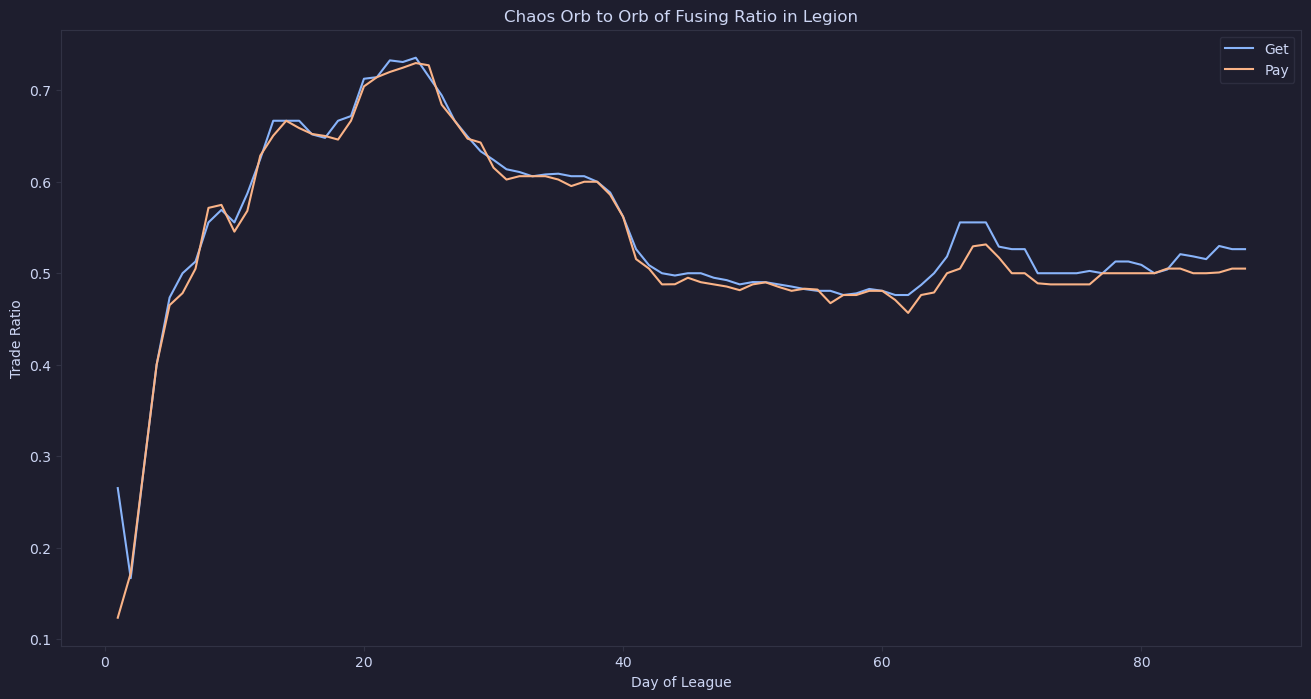

In [28]:
league = 'Legion'
currency = 'Orb of Fusing'
df = league_df(league, currency)
df = trade_ratio(df)
df = league_day(df)

plt.figure(figsize=(16,8))
plt.plot(
    df[df['Get'] == currency]['Day'],
    df[df['Get'] == currency]['Ratio'],
    label = 'Get'
)
plt.plot(
    df[df['Pay'] == currency]['Day'],
    df[df['Pay'] == currency]['Ratio'],
    label = 'Pay'
)

plt.title(f'Chaos Orb to {currency} Ratio in {league}')
plt.xlabel('Day of League')
plt.ylabel('Trade Ratio')
plt.legend()
plt.show;

Here we can see the use of the `average_ratio()` function, which will take the average of the the `Get` ratio and `Pay` ratio. We can use this as the trade ratio for any particular league.

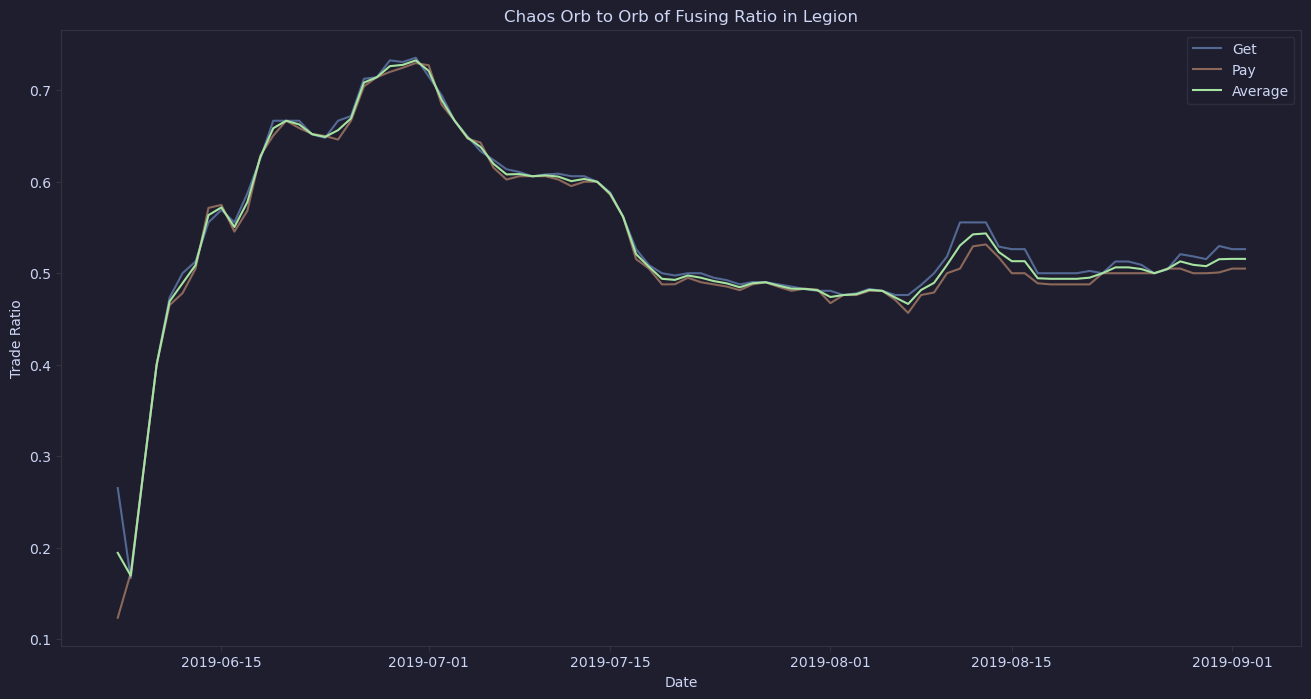

In [33]:
league = 'Legion'
currency = 'Orb of Fusing'
df = league_df(league, currency)
df = trade_ratio(df)

plt.figure(figsize=(16,8))
plt.plot(
    df[df['Get'] == currency]['Date'],
    df[df['Get'] == currency]['Ratio'],
    alpha = 0.5,
    label = 'Get'
)
plt.plot(
    df[df['Pay'] == currency]['Date'],
    df[df['Pay'] == currency]['Ratio'],
    alpha = 0.5,
    label = 'Pay'
)

df = average_ratio(df)
plt.plot(
    df['Date'],
    df['Ratio'],
    label = 'Average'
)

plt.title(f'Chaos Orb to {currency} Ratio in {league}')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Trade Ratio')
plt.show;

## Challenge Leagues

In [9]:
# List of the Currencies we will be studying.
currencies = ["Hunter's Exalted Orb", "Crusader's Exalted Orb", "Redeemer's Exalted Orb", "Warlord's Exalted Orb", "Awakener's Orb"]

### Trade Ratios Over Time

In [10]:
def league_start_graph(currency, rolling=0, diffs=0):
    '''
    This function produces plots for all the league starts (where data exists) for a specified currency
    and takes in arguements for moving average and differencing.
    
    currency: Currency to be graphed
    rolling: default = 0. If greater than 0, the function uses that as the window arguement for a moving
        average transformation.
    diffs: default = 0. If greater than 0, the function will difference the data that many times. 
    '''
    path = '../leagues/'
    plt.figure(figsize=(16,8))
    
    for league in os.listdir(path):
        color = load_color("mocha", random.choice(cat_color))
        df = league_df(league, currency)
        if df.empty:
            continue
        df = trade_ratio(df)
        df = average_ratio(df)
        df = league_day(df)
        
        if rolling>0:
            df['Ratio'] = df['Ratio'].rolling(window=rolling).mean(numeric_only=True)
            
        if diffs>0:
            for i in range(0, diffs):
                df['Ratio'] = df['Ratio'].diff()

        plt.plot(
            df['Day'],
            df['Ratio'],
            label = league,
            color = color
        )
   
    if rolling>0:
        roll_str = f' Moving Average ({rolling})'
    else:
        roll_str = ''
        
    diffs_str = ''
    
    if diffs>0:
        for i in range(0, diffs):
            diffs_str += 'Differenced '
            
    plt.title(f'Chaos Orb to {currency}{roll_str} {diffs_str}Ratio in all leagues')
    plt.legend()
    
    if rolling>0:
        plt.savefig(f'../images/{currency}_moving_all_leagues.png')
    elif diffs>0:
        for i in range(0, diffs):
            diffs_str = 'diff_'
        plt.savefig(f'../images/{currency}_{diffs_str}all_leagues.png')
    else:
        plt.savefig(f'../images/{currency}_all_leagues.png')
    
    plt.show;

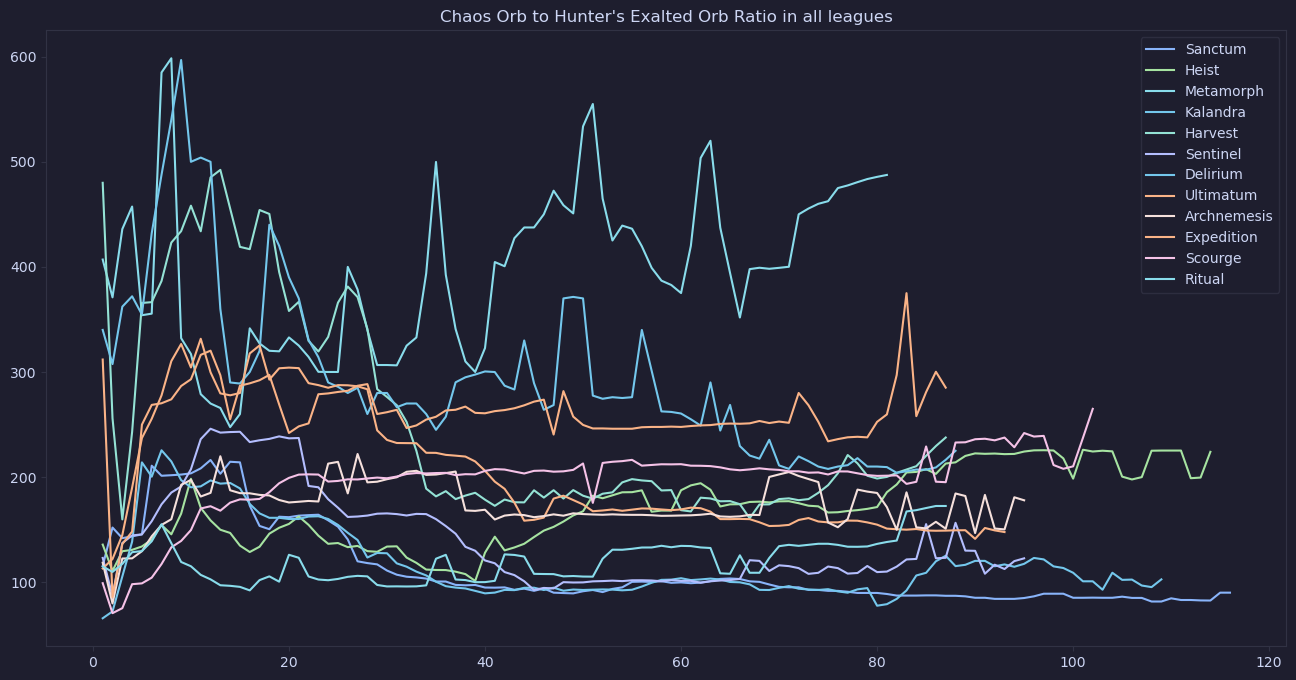

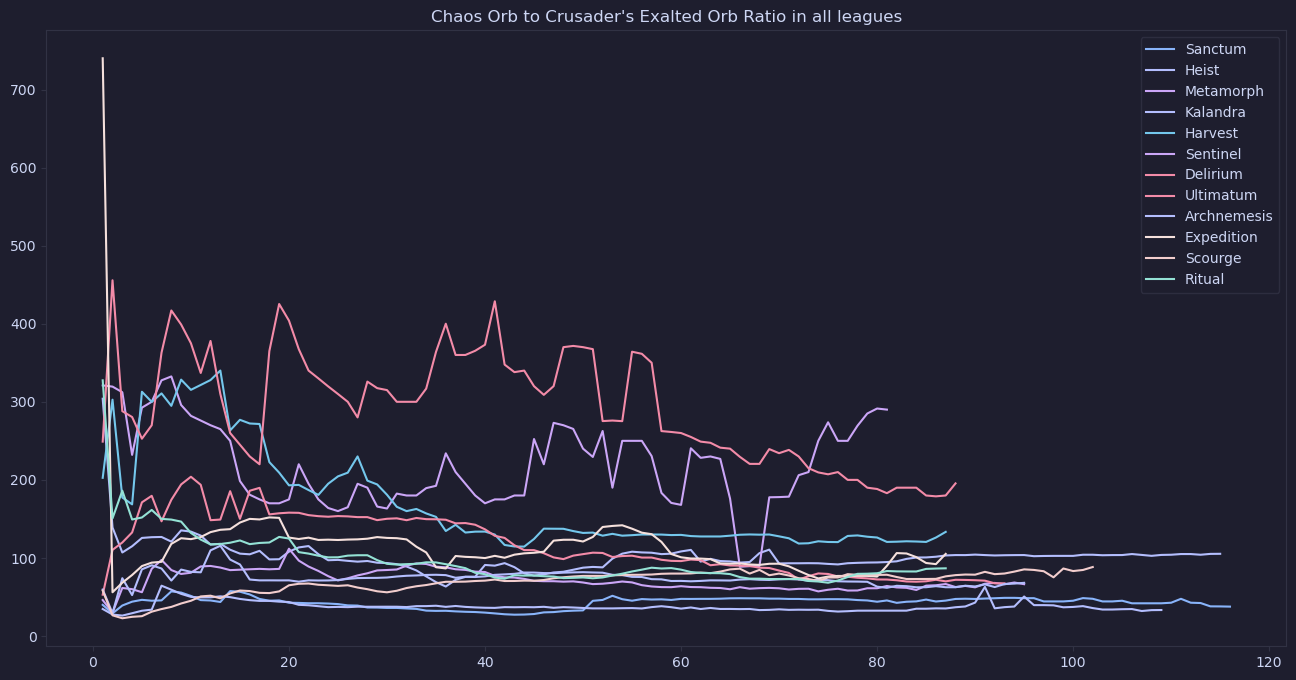

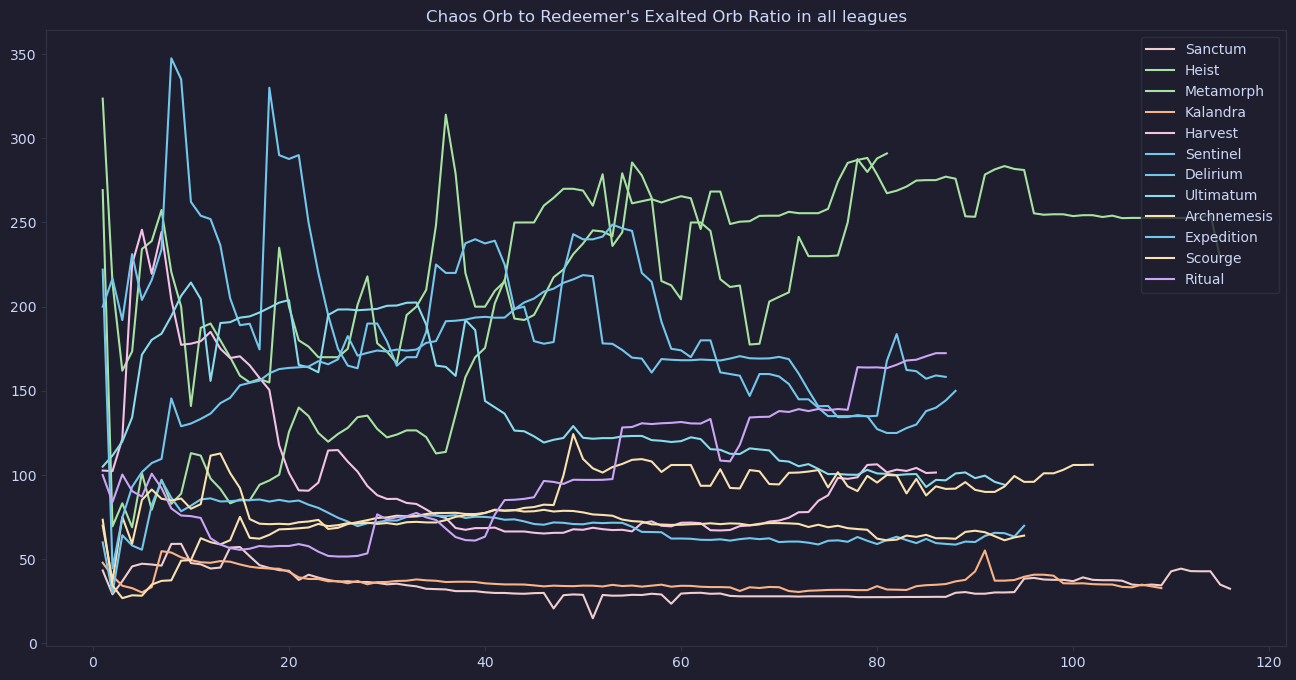

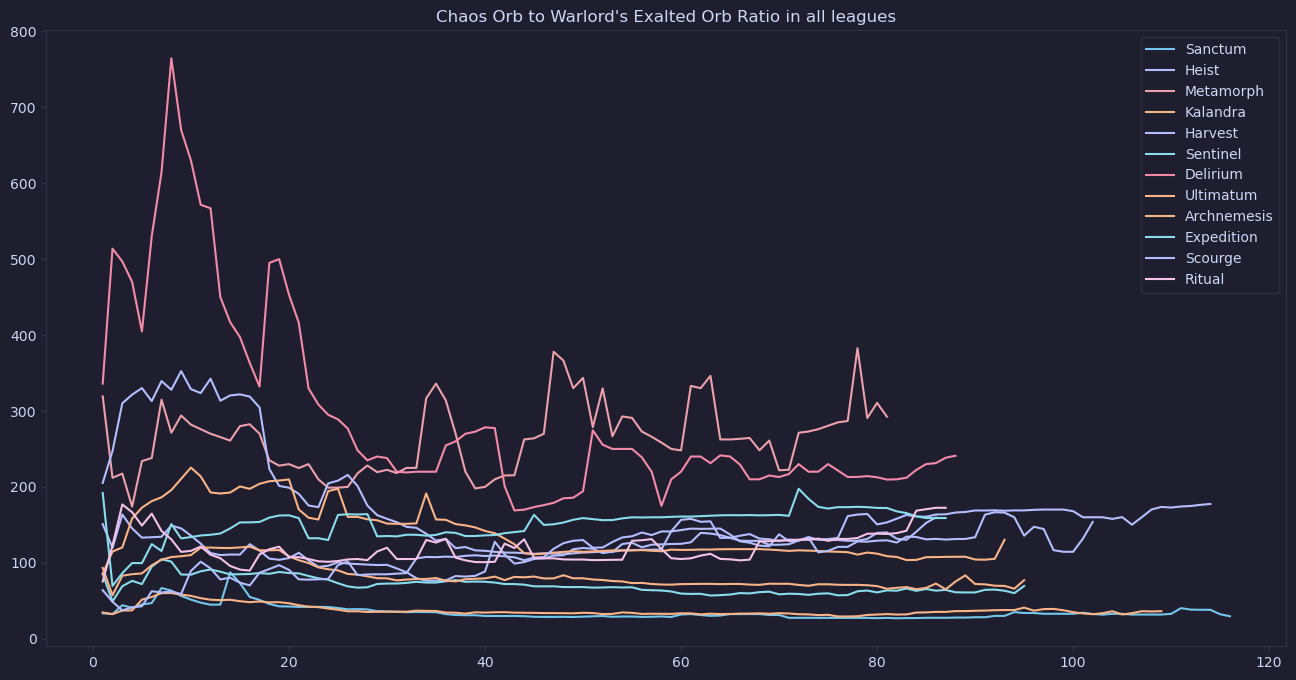

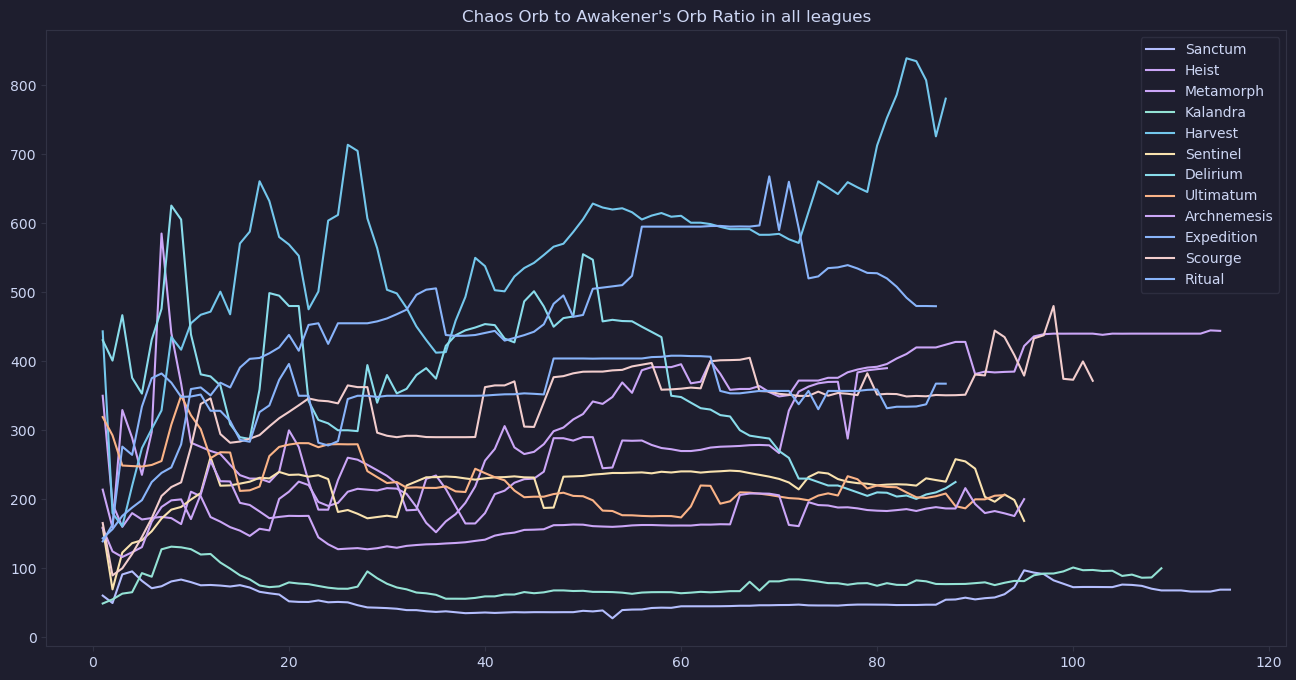

In [11]:
for currency in currencies:
    league_start_graph(currency)

### Trade Ratio Moving Average Over Time

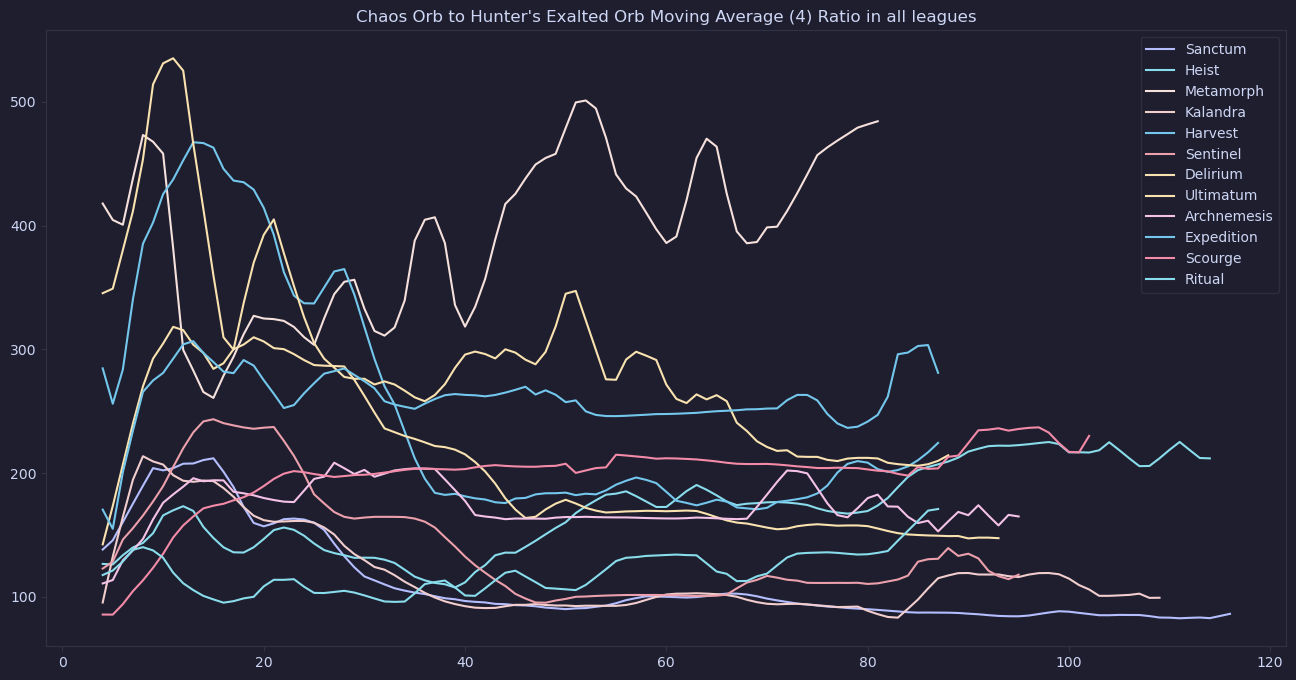

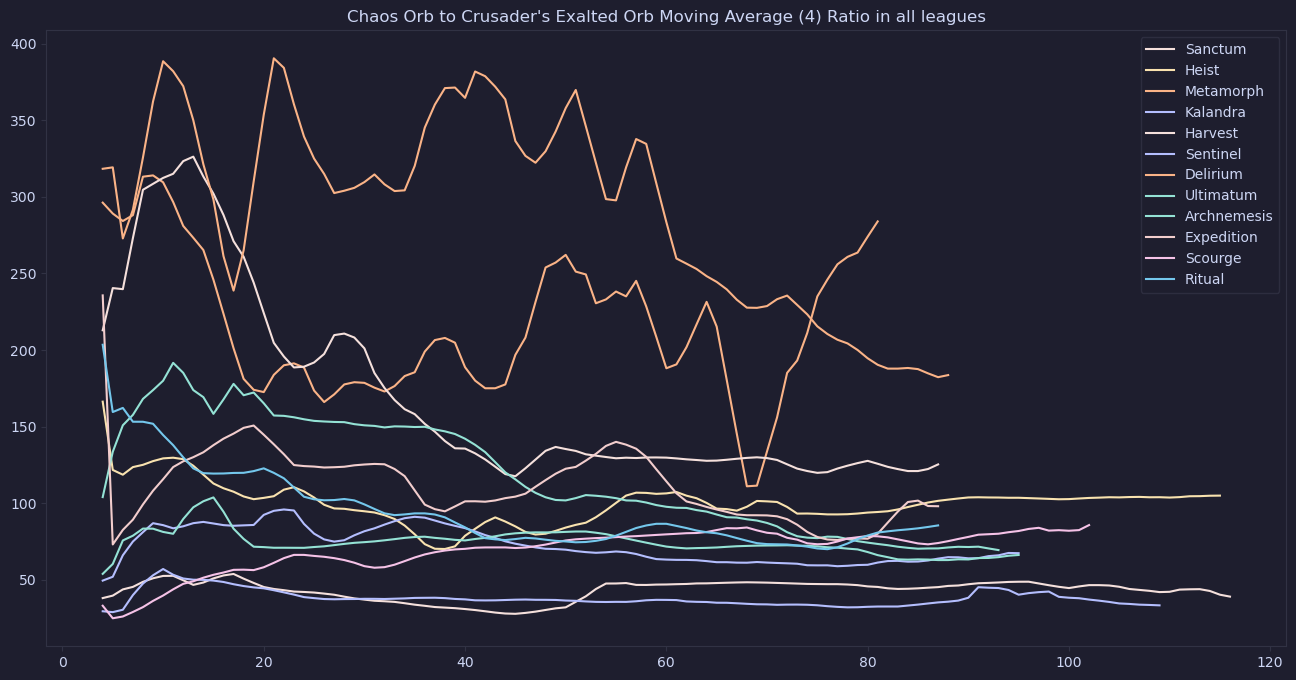

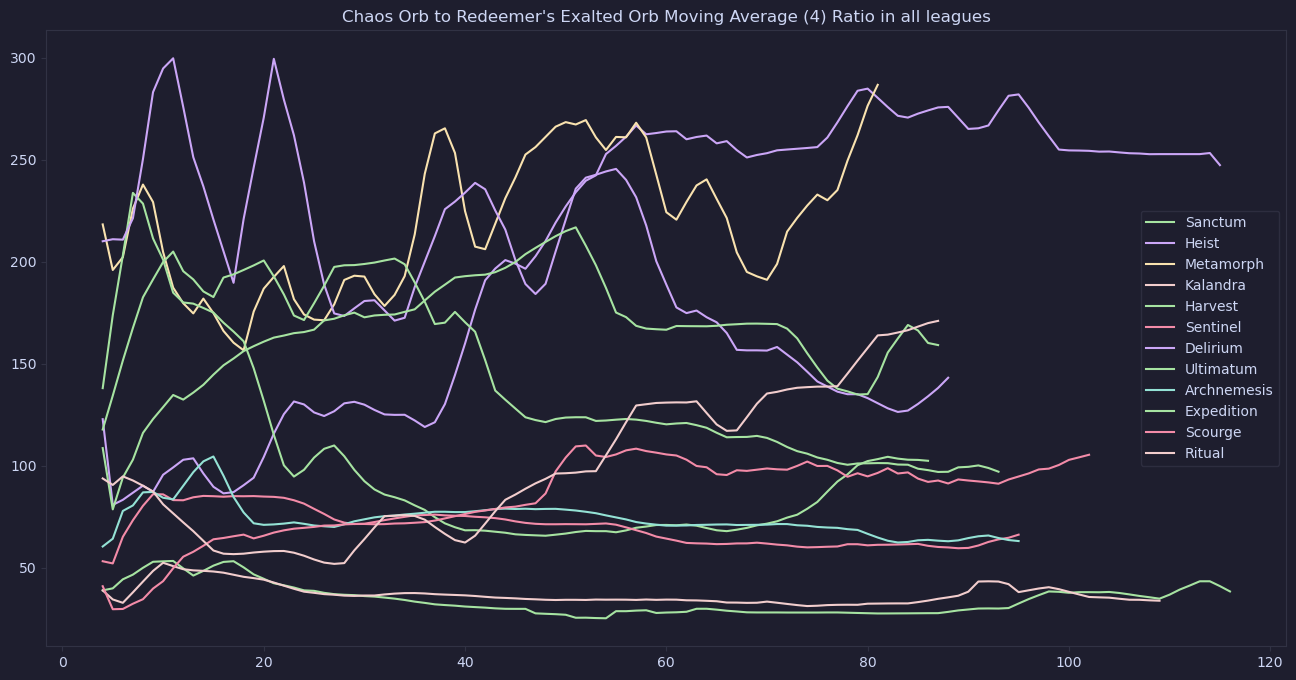

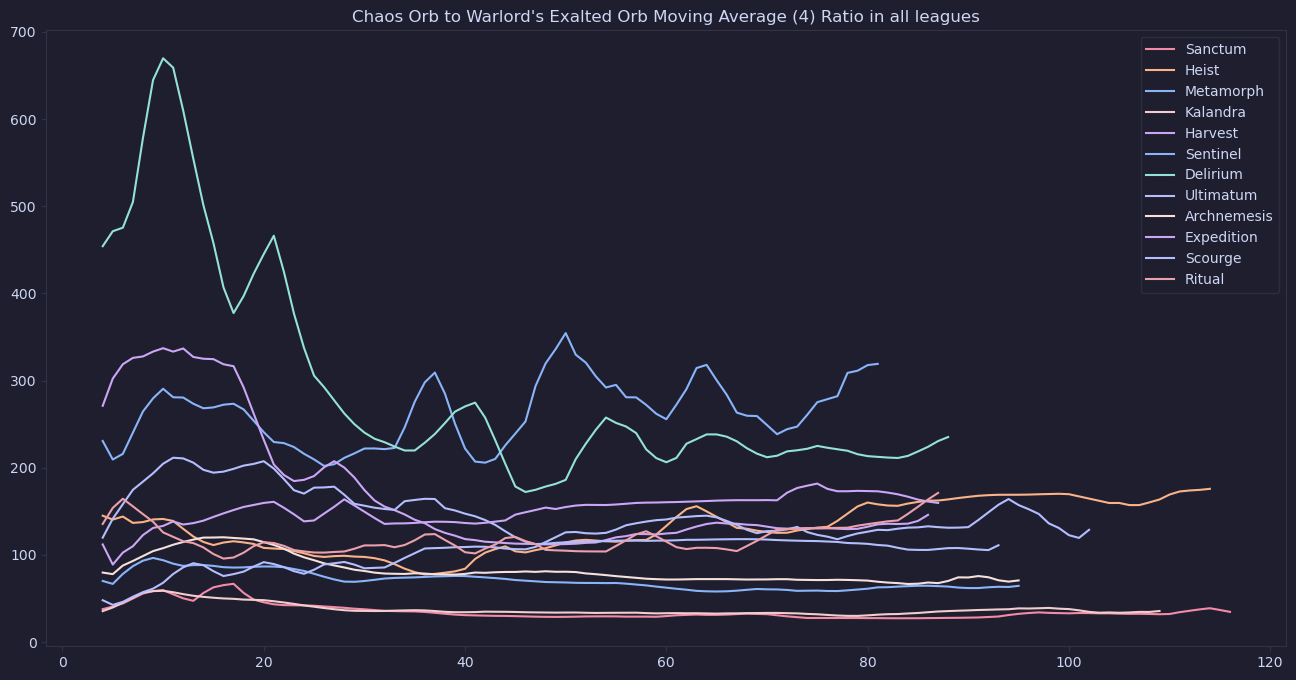

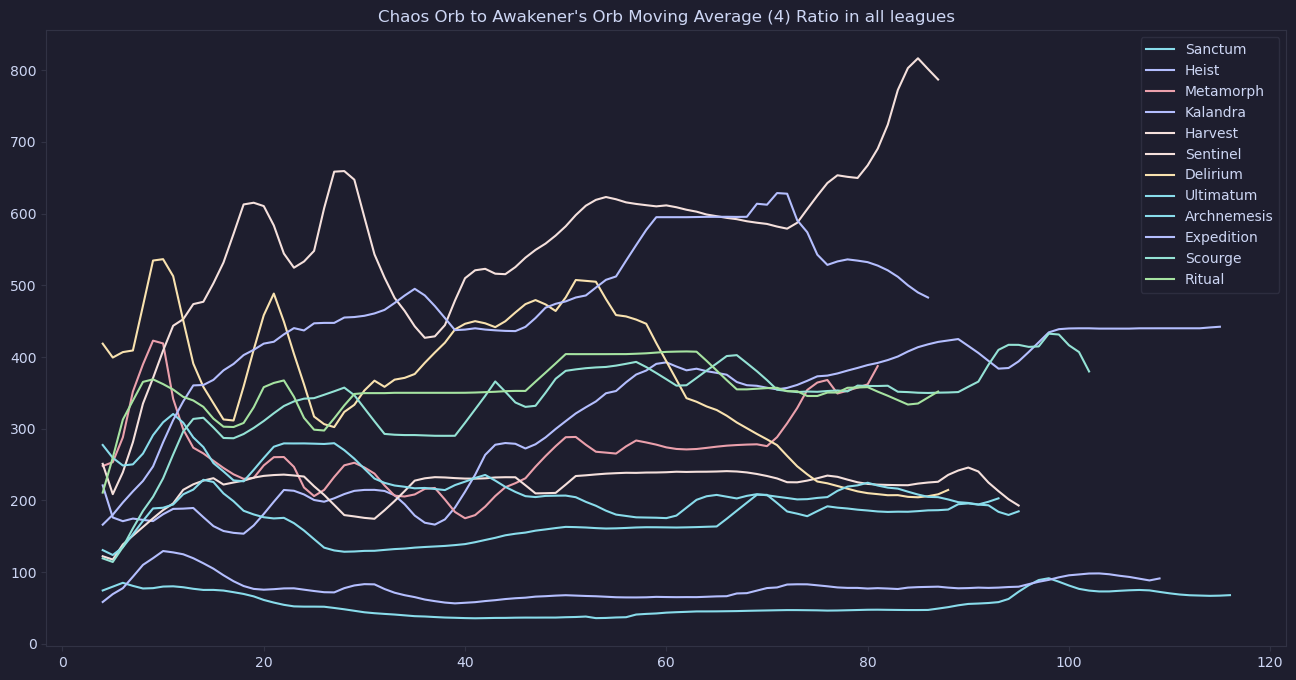

In [12]:
for currency in currencies:
    league_start_graph(currency, rolling=4)

### Trade Ratio Differencing Over Time

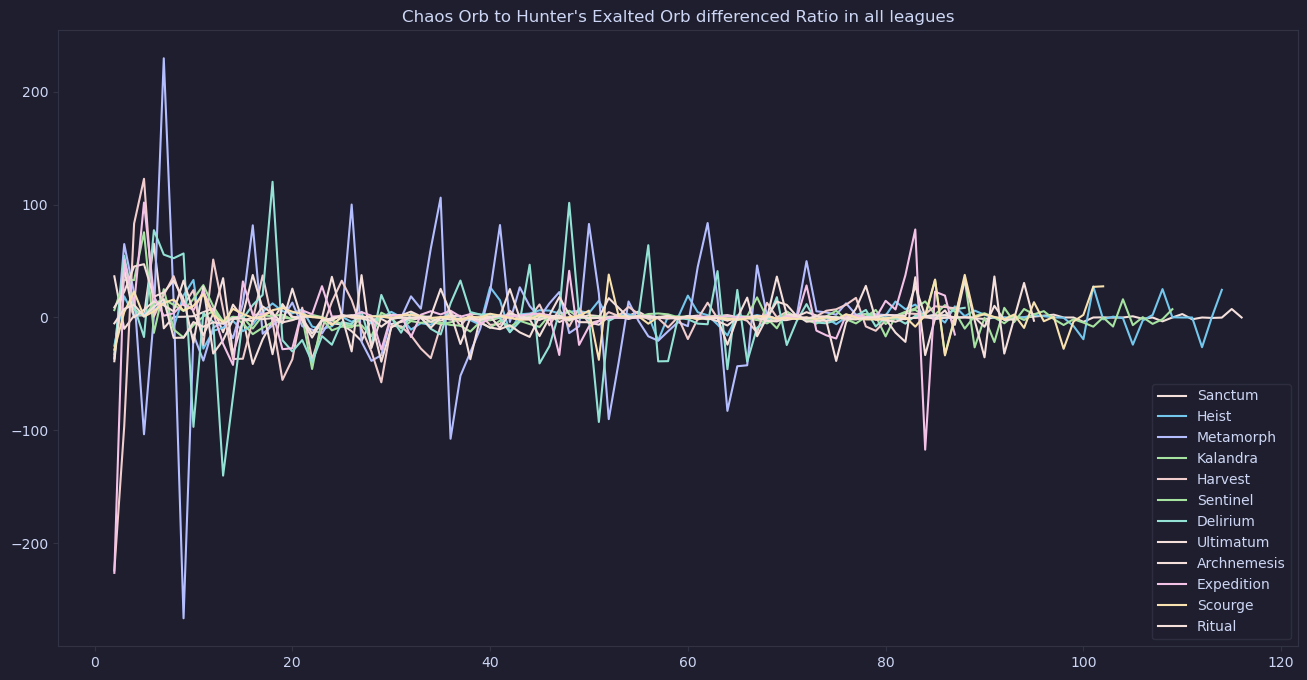

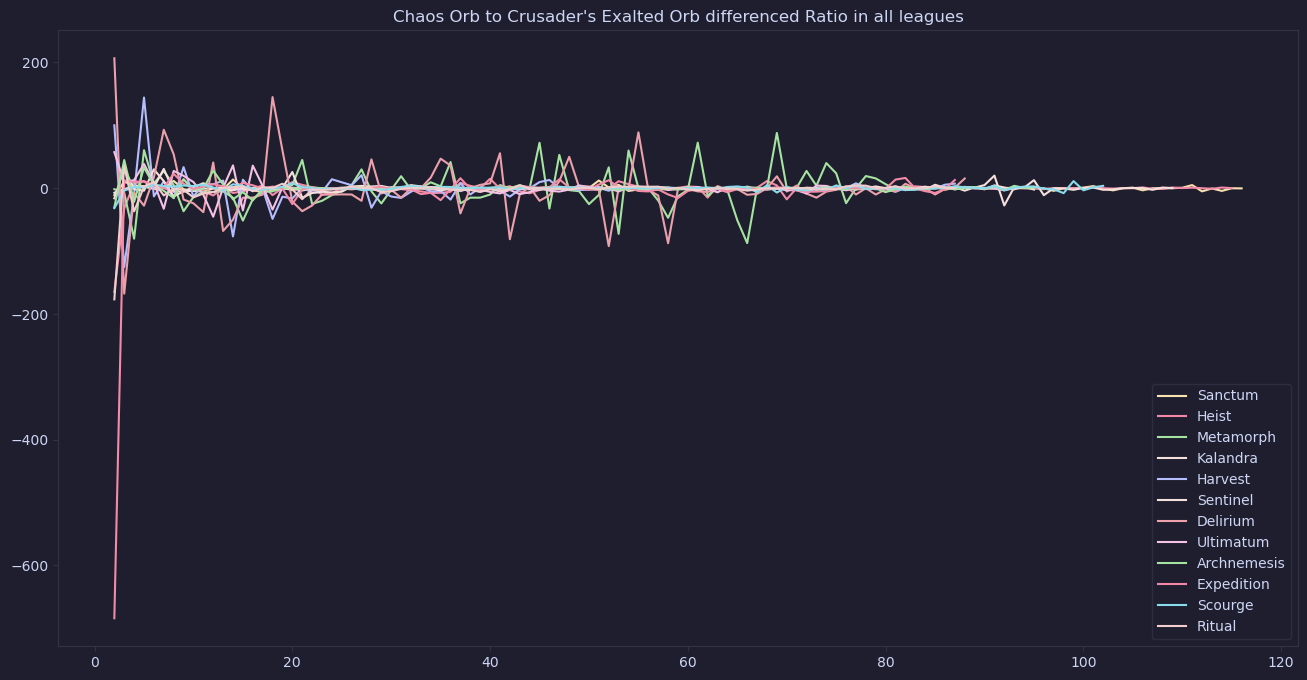

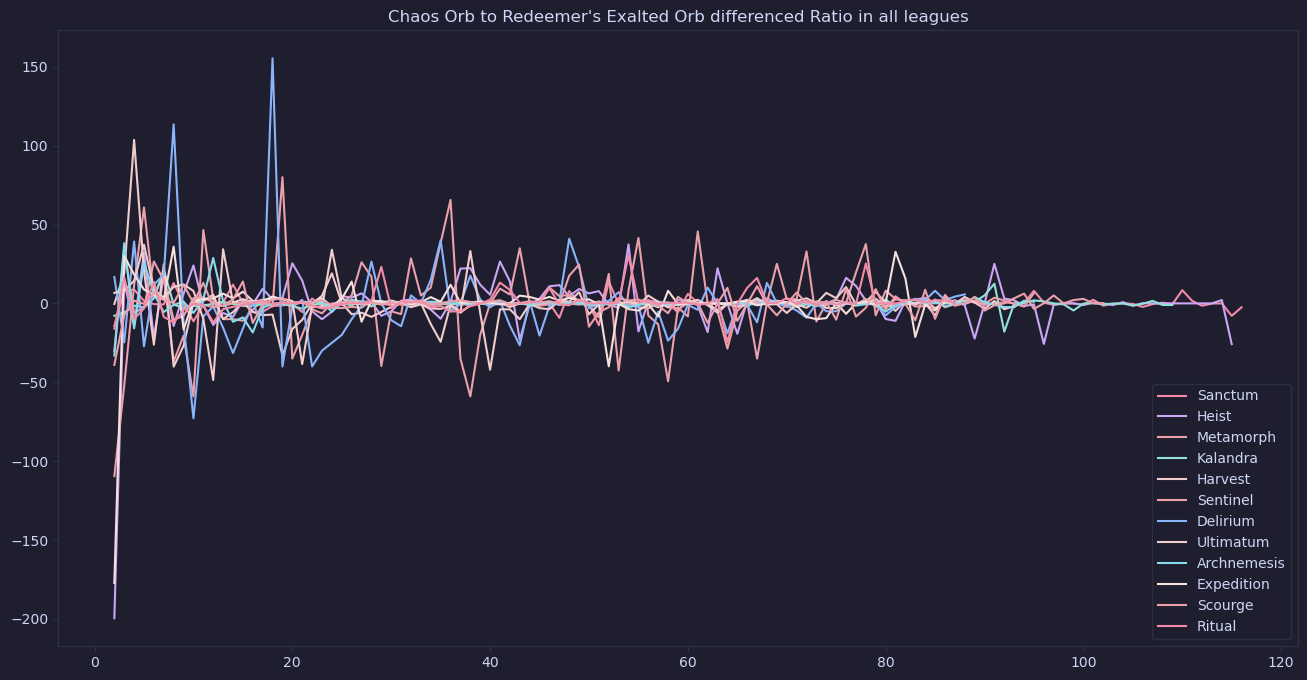

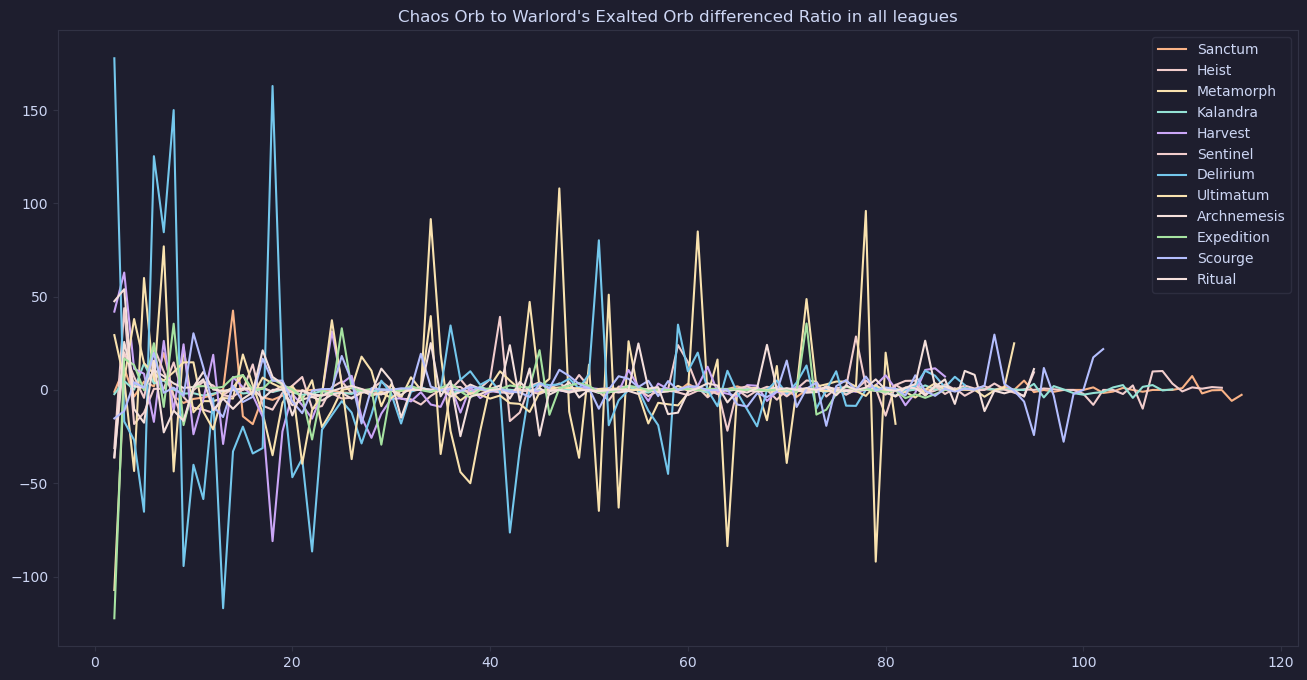

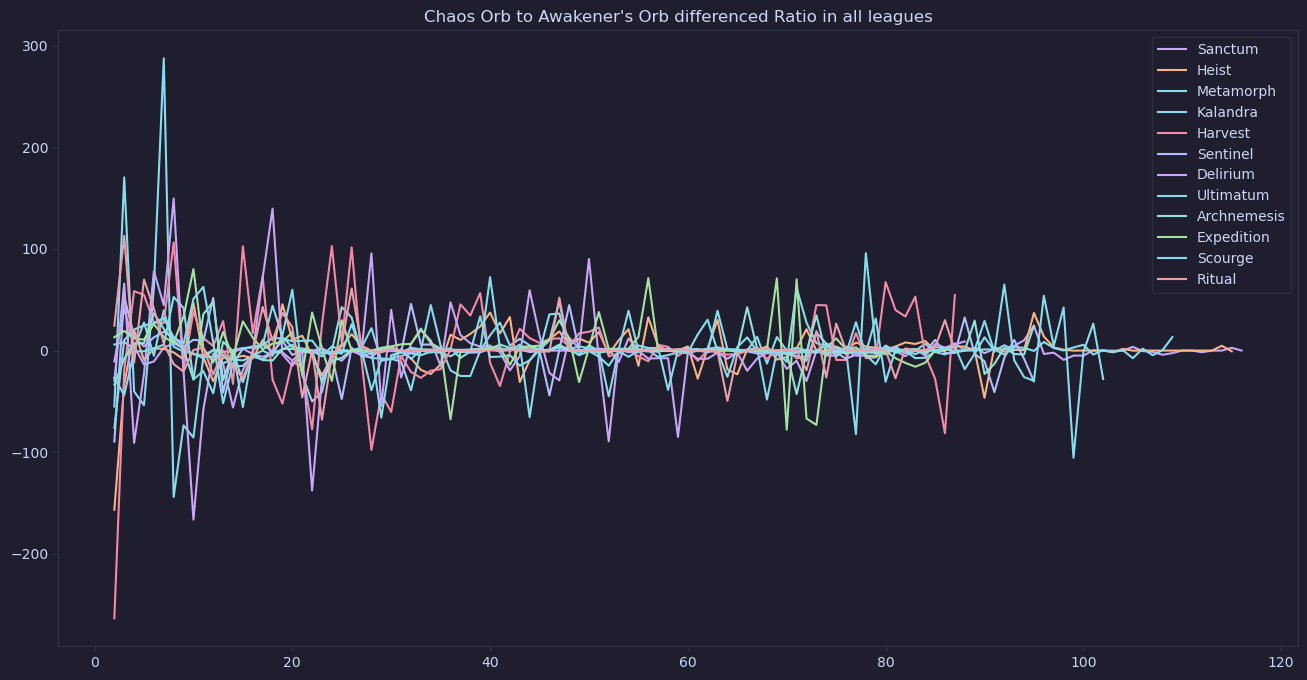

In [13]:
for currency in currencies:
    league_start_graph(currency, diffs=1)

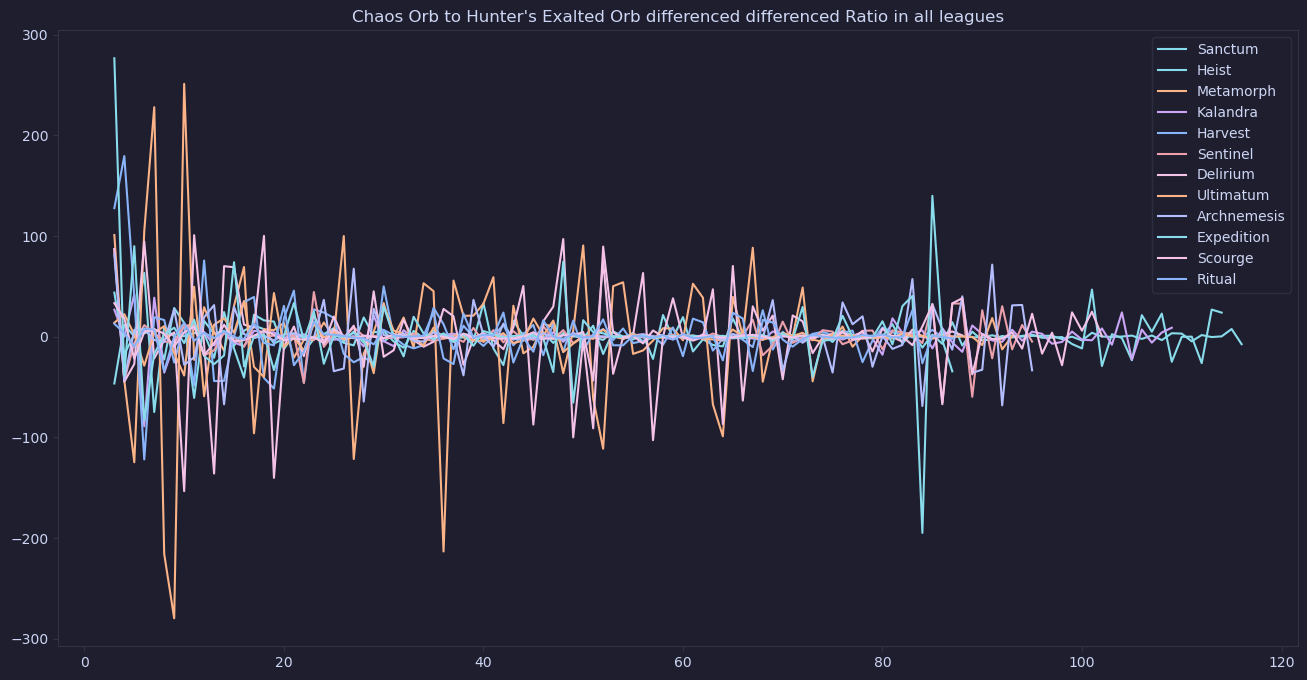

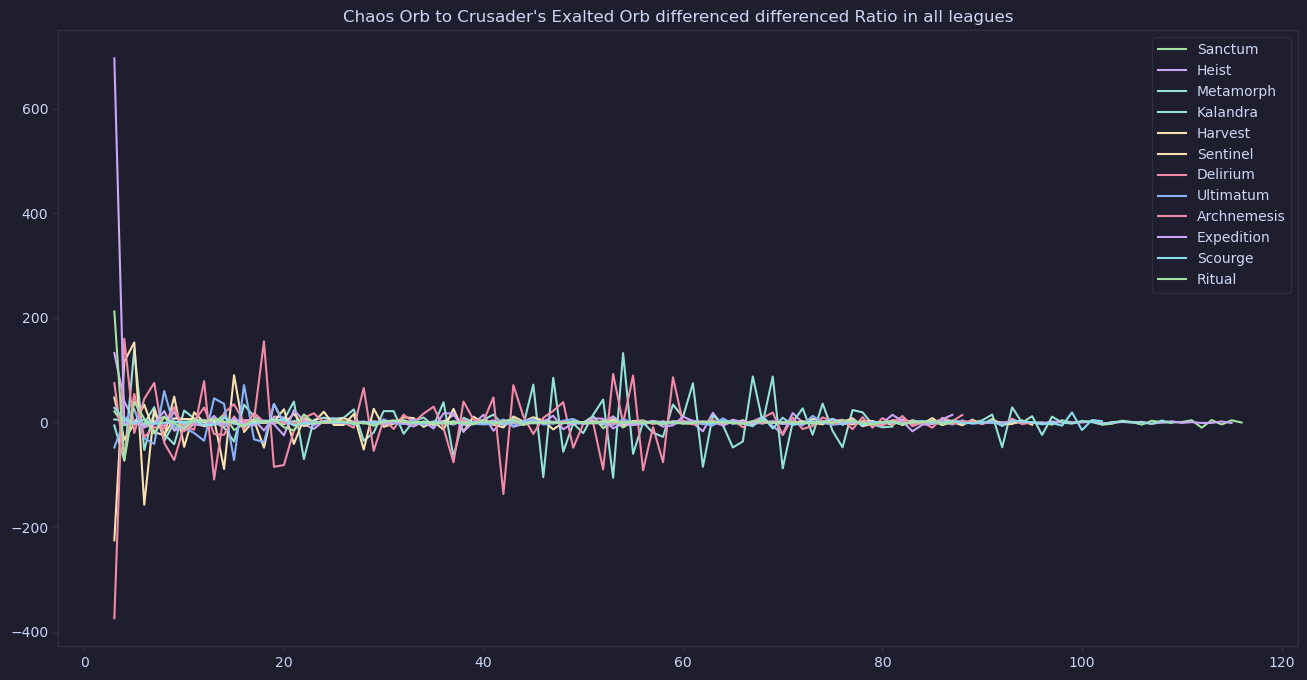

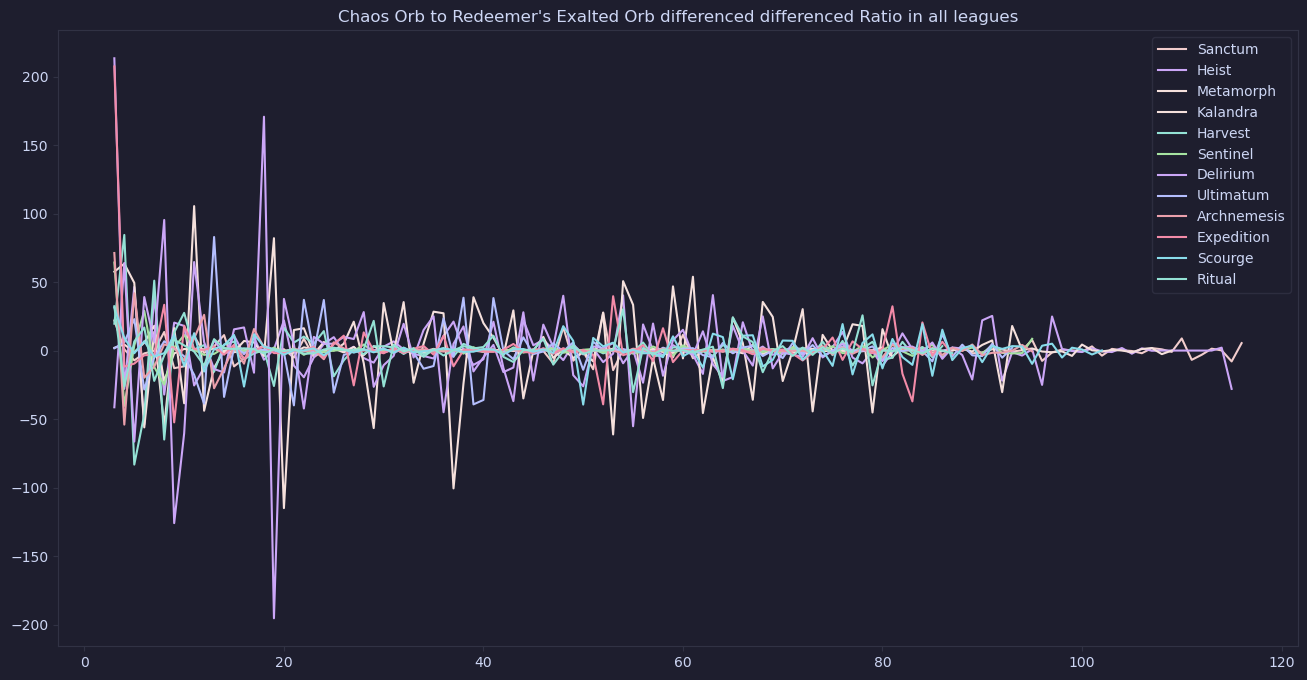

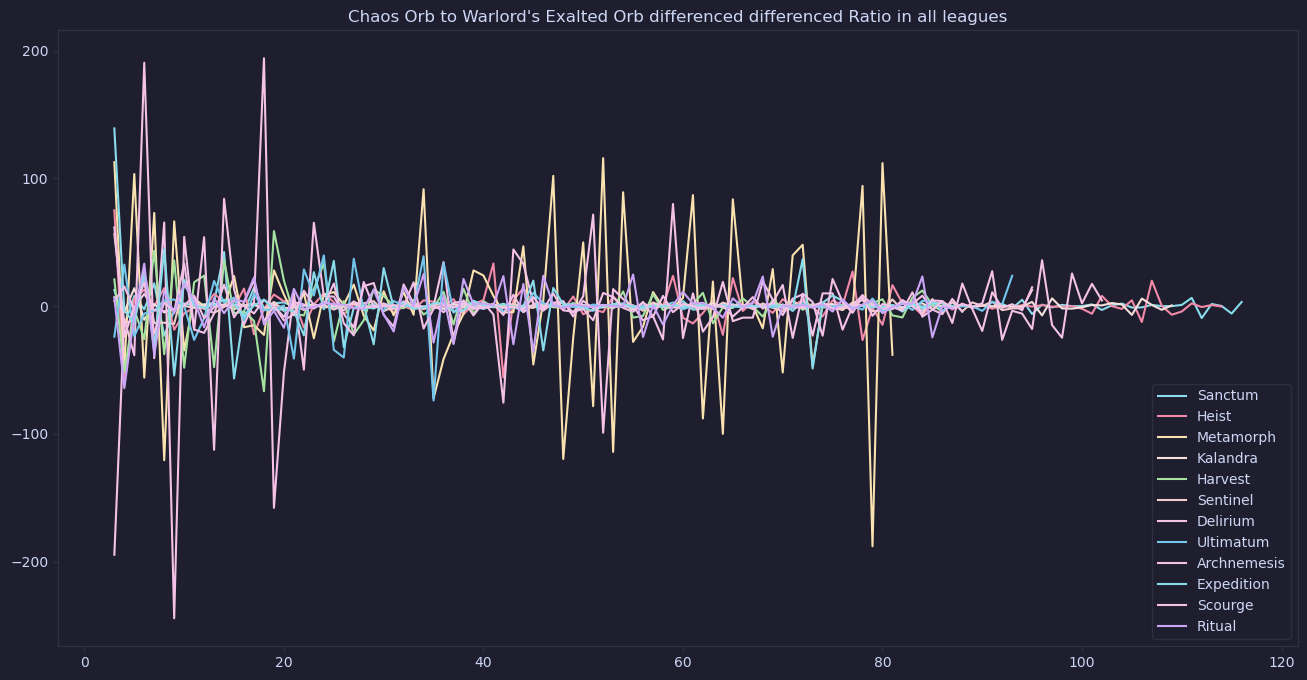

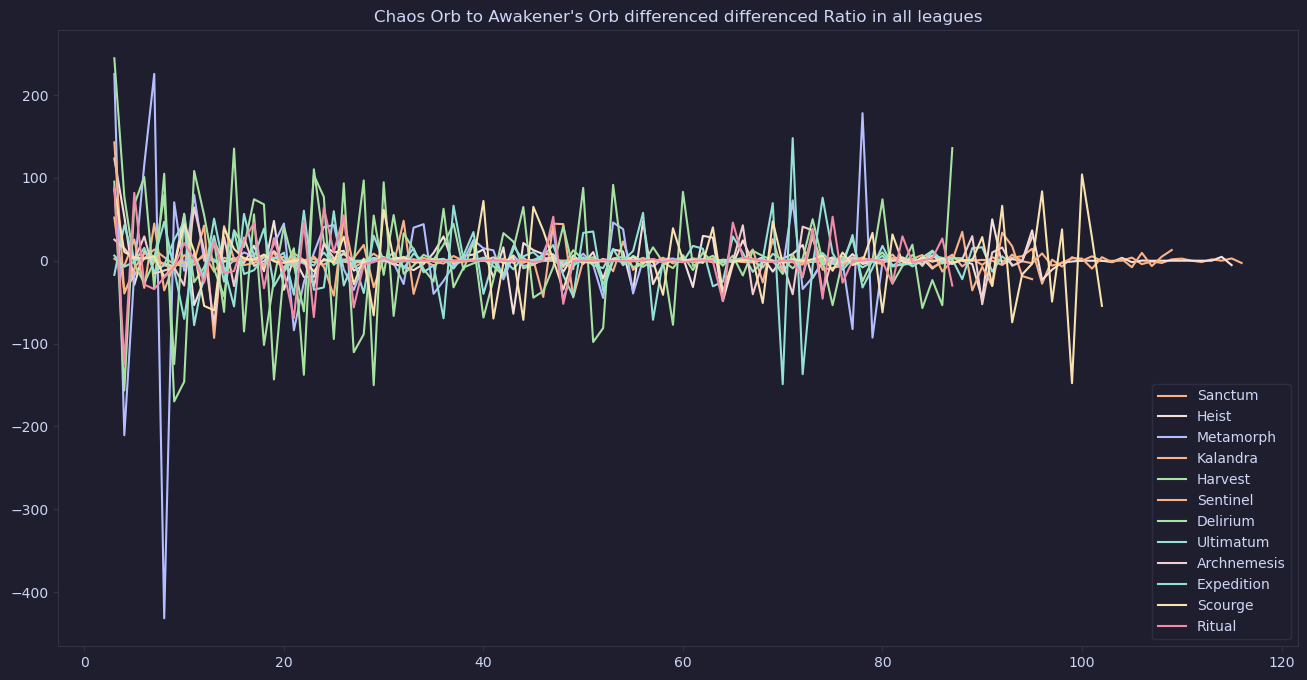

In [14]:
for currency in currencies:
    league_start_graph(currency, diffs=2)

In [15]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [69]:
def currency_dftest(currency, diffs=0):
    path = '../leagues/'
    average_p = 0
    count = 0
    result_df = pd.DataFrame(columns=['League', 'Test Statistic', 'p-value'])
    
    for league in os.listdir(path):
        df = league_df(league, currency)
        if df.empty:
            continue
        df = trade_ratio(df)
        df = average_ratio(df)
        
        if diffs>0:
            for i in range(0, diffs):
                df['Ratio'] = df['Ratio'].diff()
            df.dropna(inplace = True)
        
        adftest = interpret_dftest(adfuller(df['Ratio']))
        
        result_to_add = pd.DataFrame({
            'League': [league],
            'Test Statistic': [adftest['Test Statistic']],
            'p-value': [adftest['p-value']]
        })
        result_df = pd.concat([result_df, result_to_add], ignore_index=True)
    
    return result_df

In [128]:
def test_df_print(currency, df_list):
    df = df_list[currency]
    print(f"The Average p-value for {currency} is {df['p-value'].mean()}")

    print(df)

In [129]:
test_dfs = {}
for currency in currencies:
    df = currency_dftest(currency, diffs=0)
    test_dfs[currency] = df

In [130]:
test_df_print(currencies[0], test_dfs)

The Average p-value for Hunter's Exalted Orb is 0.2583440784710172
         League  Test Statistic       p-value
0       Sanctum       -9.699851  1.079497e-16
1         Heist       -1.348307  6.067927e-01
2     Metamorph       -2.306097  1.700092e-01
3      Kalandra       -1.876077  3.433978e-01
4       Harvest       -0.914264  7.832386e-01
5      Sentinel       -1.334480  6.132537e-01
6      Delirium       -4.169879  7.406748e-04
7     Ultimatum       -3.375993  1.180502e-02
8   Archnemesis       -3.550041  6.791180e-03
9    Expedition       -5.307018  5.295300e-06
10      Scourge       -4.167570  7.473226e-04
11       Ritual       -1.439196  5.633474e-01


In [131]:
test_df_print(currencies[1], test_dfs)

The Average p-value for Crusader's Exalted Orb is 0.13503600938821056
         League  Test Statistic   p-value
0       Sanctum       -2.427729  0.134063
1         Heist       -2.555144  0.102627
2     Metamorph       -2.825537  0.054718
3      Kalandra       -2.891613  0.046332
4       Harvest       -4.162712  0.000761
5      Sentinel       -2.940799  0.040805
6      Delirium       -1.653435  0.455249
7     Ultimatum       -1.600768  0.483208
8   Archnemesis       -2.727204  0.069448
9    Expedition       -2.238587  0.192540
10      Scourge       -2.941994  0.040678
11       Ritual       -5.401317  0.000003


In [132]:
test_df_print(currencies[2], test_dfs)

The Average p-value for Redeemer's Exalted Orb is 0.3170005515222338
         League  Test Statistic   p-value
0       Sanctum       -1.777413  0.391732
1         Heist       -1.740880  0.410182
2     Metamorph       -3.626292  0.005278
3      Kalandra       -2.690286  0.075734
4       Harvest       -5.248468  0.000007
5      Sentinel       -1.859694  0.351253
6      Delirium       -1.219133  0.665312
7     Ultimatum       -0.932918  0.776939
8   Archnemesis       -4.118019  0.000904
9    Expedition       -3.748701  0.003478
10      Scourge       -2.343569  0.158301
11       Ritual        0.083073  0.964886


In [133]:
test_df_print(currencies[3], test_dfs)

The Average p-value for Warlord's Exalted Orb is 0.19555283043452398
         League  Test Statistic   p-value
0       Sanctum       -1.546849  0.510222
1         Heist       -1.419854  0.572722
2     Metamorph       -4.019343  0.001313
3      Kalandra       -3.230475  0.018287
4       Harvest       -2.347255  0.157180
5      Sentinel       -2.857421  0.050528
6      Delirium       -3.537543  0.007074
7     Ultimatum       -3.186328  0.020790
8   Archnemesis       -1.826588  0.367344
9    Expedition       -4.298923  0.000446
10      Scourge       -2.287644  0.175984
11       Ritual       -1.635246  0.464746


In [134]:
test_df_print(currencies[4], test_dfs)

The Average p-value for Awakener's Orb is 0.19522788309766945
         League  Test Statistic   p-value
0       Sanctum       -2.219183  0.199357
1         Heist       -1.116473  0.708458
2     Metamorph       -3.365794  0.012182
3      Kalandra       -2.334805  0.160988
4       Harvest       -3.099502  0.026590
5      Sentinel       -4.867891  0.000040
6      Delirium       -1.351943  0.605086
7     Ultimatum       -2.250223  0.188525
8   Archnemesis       -2.405898  0.140079
9    Expedition       -3.312704  0.014320
10      Scourge       -2.727130  0.069460
11       Ritual       -2.169104  0.217649


In [135]:
test_dfs = {}
for currency in currencies:
    df = currency_dftest(currency, diffs=1)
    test_dfs[currency] = df

In [136]:
test_df_print(currencies[0], test_dfs)

The Average p-value for Hunter's Exalted Orb is 0.03602292028058726
         League  Test Statistic       p-value
0       Sanctum       -2.213374  2.014272e-01
1         Heist       -6.447200  1.555251e-08
2     Metamorph       -5.463135  2.492721e-06
3      Kalandra       -7.912456  3.914977e-12
4       Harvest      -11.144774  3.045340e-20
5      Sentinel      -11.436577  6.326386e-21
6      Delirium       -6.186776  6.261586e-08
7     Ultimatum       -2.134576  2.308404e-01
8   Archnemesis       -5.325698  4.842932e-06
9    Expedition       -8.058892  1.663541e-12
10      Scourge       -8.403877  2.194119e-13
11       Ritual       -7.742122  1.055121e-11


In [137]:
test_df_print(currencies[1], test_dfs)

The Average p-value for Crusader's Exalted Orb is 0.0018125351962361513
         League  Test Statistic       p-value
0       Sanctum       -7.964769  2.884633e-12
1         Heist      -28.911211  0.000000e+00
2     Metamorph       -9.539787  2.746301e-16
3      Kalandra       -6.456790  1.476624e-08
4       Harvest       -3.233174  1.814295e-02
5      Sentinel      -11.326015  1.143035e-20
6      Delirium       -5.999130  1.673661e-07
7     Ultimatum       -3.738167  3.607229e-03
8   Archnemesis       -8.489264  1.327067e-13
9    Expedition       -6.199496  5.854129e-08
10      Scourge      -14.421434  7.900062e-27
11       Ritual      -43.650004  0.000000e+00


In [138]:
test_df_print(currencies[2], test_dfs)

The Average p-value for Redeemer's Exalted Orb is 0.04991249496350598
         League  Test Statistic       p-value
0       Sanctum       -5.897684  2.825999e-07
1         Heist      -22.256248  0.000000e+00
2     Metamorph       -7.830211  6.322536e-12
3      Kalandra       -4.787283  5.751568e-05
4       Harvest       -1.558633  5.043330e-01
5      Sentinel       -2.601221  9.274521e-02
6      Delirium       -3.936652  1.781069e-03
7     Ultimatum       -6.279472  3.827843e-08
8   Archnemesis       -4.913660  3.280090e-05
9    Expedition      -24.276910  0.000000e+00
10      Scourge      -10.095396  1.094267e-17
11       Ritual       -9.655029  1.401571e-16


In [139]:
test_df_print(currencies[3], test_dfs)

The Average p-value for Warlord's Exalted Orb is 0.05519184237810288
         League  Test Statistic       p-value
0       Sanctum       -7.295609  1.380562e-10
1         Heist       -7.331794  1.122842e-10
2     Metamorph      -11.636258  2.201173e-21
3      Kalandra       -3.205210  1.968510e-02
4       Harvest       -3.064610  2.928551e-02
5      Sentinel       -9.367898  7.513506e-16
6      Delirium       -1.844750  3.584816e-01
7     Ultimatum       -2.150404  2.247355e-01
8   Archnemesis       -3.637854  5.077241e-03
9    Expedition       -7.117197  3.803751e-10
10      Scourge       -5.307543  5.282060e-06
11       Ritual       -3.121082  2.503186e-02


In [140]:
test_df_print(currencies[4], test_dfs)

The Average p-value for Awakener's Orb is 0.03128219834962649
         League  Test Statistic       p-value
0       Sanctum       -8.471721  1.471536e-13
1         Heist       -3.062551  2.945163e-02
2     Metamorph       -4.229613  5.868394e-04
3      Kalandra      -10.367829  2.305453e-18
4       Harvest       -5.211482  8.329721e-06
5      Sentinel       -7.378979  8.571927e-11
6      Delirium       -1.872013  3.453394e-01
7     Ultimatum       -5.945202  2.212625e-07
8   Archnemesis       -9.175266  2.329361e-15
9    Expedition      -10.410445  1.809966e-18
10      Scourge       -6.952273  9.624658e-10
11       Ritual       -7.182104  2.633545e-10


In [141]:
test_dfs = {}
for currency in currencies:
    df = currency_dftest(currency, diffs=2)
    test_dfs[currency] = df

In [142]:
test_df_print(currencies[0], test_dfs)

The Average p-value for Hunter's Exalted Orb is 0.0006455302451702083
         League  Test Statistic       p-value
0       Sanctum      -11.321312  1.172286e-20
1         Heist       -6.030497  1.421808e-07
2     Metamorph       -6.617640  6.149749e-09
3      Kalandra       -8.295350  4.154454e-13
4       Harvest       -7.582546  2.658299e-11
5      Sentinel      -10.372260  2.248121e-18
6      Delirium       -7.305293  1.306340e-10
7     Ultimatum       -4.844064  4.475741e-05
8   Archnemesis       -3.513041  7.658415e-03
9    Expedition       -5.045538  1.802034e-05
10      Scourge       -5.246009  7.076880e-06
11       Ritual       -5.046452  1.794484e-05


In [143]:
test_df_print(currencies[1], test_dfs)

The Average p-value for Crusader's Exalted Orb is 0.003267028010701735
         League  Test Statistic       p-value
0       Sanctum       -8.729967  3.211420e-14
1         Heist       -6.902695  1.270071e-09
2     Metamorph       -5.813271  4.351166e-07
3      Kalandra      -10.082115  1.181099e-17
4       Harvest       -3.480278  8.508275e-03
5      Sentinel       -7.229300  2.014207e-10
6      Delirium       -5.604253  1.244617e-06
7     Ultimatum       -3.053426  3.019742e-02
8   Archnemesis       -4.518696  1.818968e-04
9    Expedition       -7.202431  2.346530e-10
10      Scourge       -5.900660  2.783118e-07
11       Ritual       -4.385570  3.147820e-04


In [144]:
test_df_print(currencies[2], test_dfs)

The Average p-value for Redeemer's Exalted Orb is 0.0005353521654683038
         League  Test Statistic       p-value
0       Sanctum       -7.031132  6.181258e-10
1         Heist       -6.722627  3.452244e-09
2     Metamorph       -6.064772  1.189024e-07
3      Kalandra      -11.012350  6.279178e-20
4       Harvest       -3.567023  6.423685e-03
5      Sentinel       -6.444402  1.578959e-08
6      Delirium       -5.847105  3.661740e-07
7     Ultimatum       -6.312176  3.214588e-08
8   Archnemesis       -6.774243  2.595035e-09
9    Expedition       -9.087381  3.906981e-15
10      Scourge       -7.677552  1.534420e-11
11       Ritual       -6.866972  1.550182e-09


In [145]:
test_df_print(currencies[3], test_dfs)

The Average p-value for Warlord's Exalted Orb is 2.3799600047939137e-06
         League  Test Statistic       p-value
0       Sanctum       -6.972940  8.571800e-10
1         Heist       -8.304151  3.944988e-13
2     Metamorph       -8.020048  2.088110e-12
3      Kalandra       -7.565641  2.930797e-11
4       Harvest       -5.750560  5.980235e-07
5      Sentinel       -8.051659  1.735491e-12
6      Delirium       -7.587614  2.581630e-11
7     Ultimatum       -6.035861  1.382628e-07
8   Archnemesis       -5.301995  5.423800e-06
9    Expedition       -6.465721  1.406933e-08
10      Scourge       -5.986418  1.787756e-07
11       Ritual       -4.999876  2.220567e-05


In [146]:
test_df_print(currencies[4], test_dfs)

The Average p-value for Awakener's Orb is 3.132223328937576e-05
         League  Test Statistic       p-value
0       Sanctum       -6.828223  1.923320e-09
1         Heist       -4.363570  3.441390e-04
2     Metamorph       -5.100583  1.398123e-05
3      Kalandra       -6.440851  1.609554e-08
4       Harvest       -8.335581  3.279284e-13
5      Sentinel       -8.999098  6.571308e-15
6      Delirium       -7.143165  3.283956e-10
7     Ultimatum       -5.863421  3.368672e-07
8   Archnemesis       -5.054443  1.729803e-05
9    Expedition       -7.404416  7.409263e-11
10      Scourge       -6.113566  9.208689e-08
11       Ritual       -6.920421  1.150290e-09


## Standard

In [150]:
def standard_graph(currency, rolling=0, diffs=0):
    '''
    This is a similar function to the graphing function we had before, but instead is designed around the standard league, which is permanent, and therefore
    is a more traditional time series data set.
    
    currency: target currency to be graphed
    rolling: default = 0. Used to set the window for moving average
    diffs: default = 0. Used to the differencing desired.
    '''
    plt.figure(figsize=(16,8))
    
    df = league_df(currency=currency)
    df = trade_ratio(df)
    df = average_ratio(df)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    df = df.resample('W').mean()

    if rolling>0:
        df['Ratio'] = df['Ratio'].rolling(window=rolling).mean(numeric_only=True)
            
    if diffs>0:
        for i in range(0, diffs):
            df['Ratio'] = df['Ratio'].diff()

    plt.plot(
        df['Ratio'],
    )
    
    if rolling>0:
        roll_str = f' Moving Average ({rolling})'
    else:
        roll_str = ''
        
    diffs_str = ''
    
    if diffs>0:
        for i in range(0, diffs):
            diffs_str += 'Differenced '
   
    plt.title(f'Chaos Orb to {currency}{roll_str} {diffs_str}Ratio in standard')
    plt.xlabel('Date')
    plt.ylabel('Chaos Trade Ratio')
    
    if rolling>0:
        plt.savefig(f'../images/{currency}_moving_standard.png')
    elif diffs>0:
        for i in range(0, diffs):
            diffs_str = 'diff_'
        plt.savefig(f'../images/{currency}_{diffs_str}standard.png')
    else:
        plt.savefig(f'../images/{currency}_standard.png')
 
    plt.show;

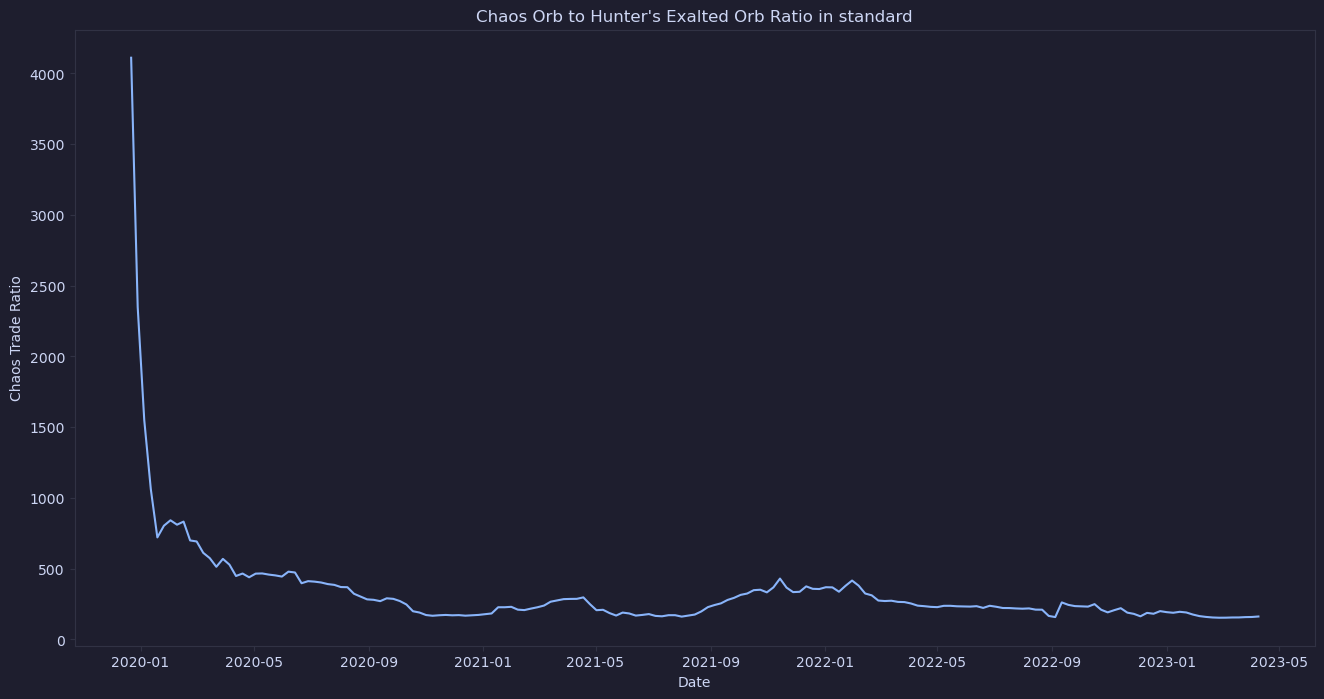

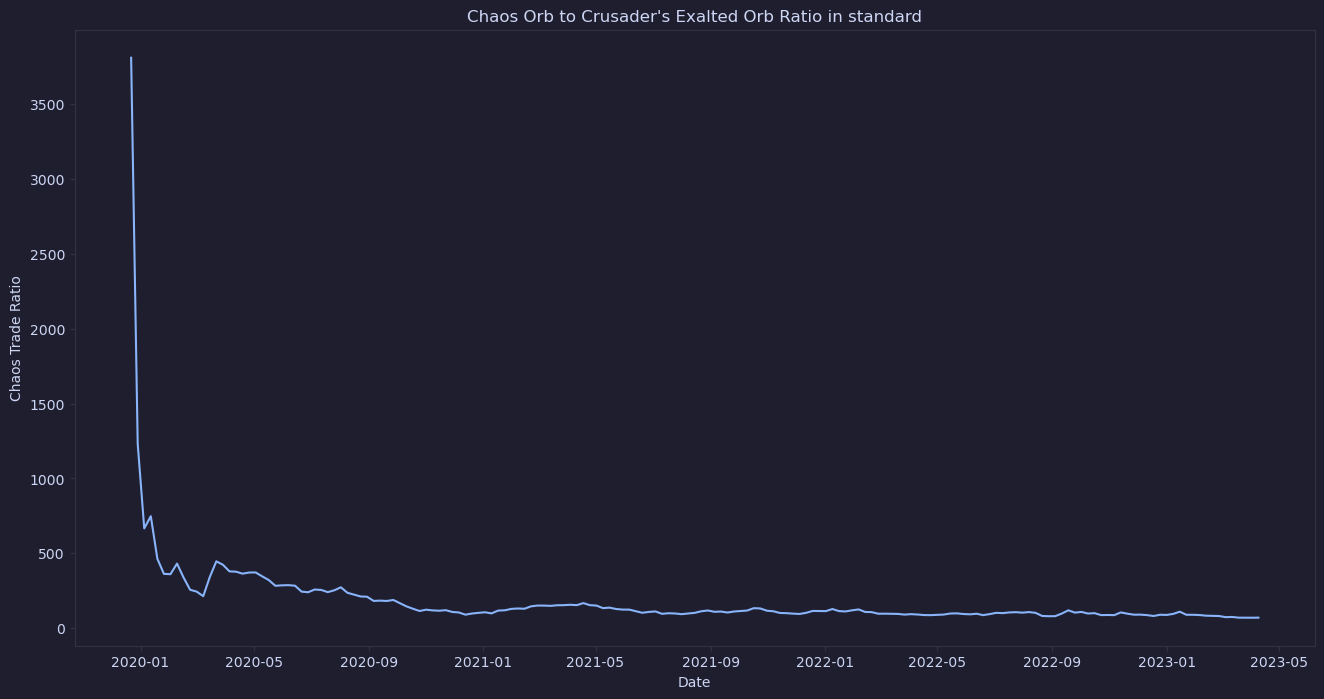

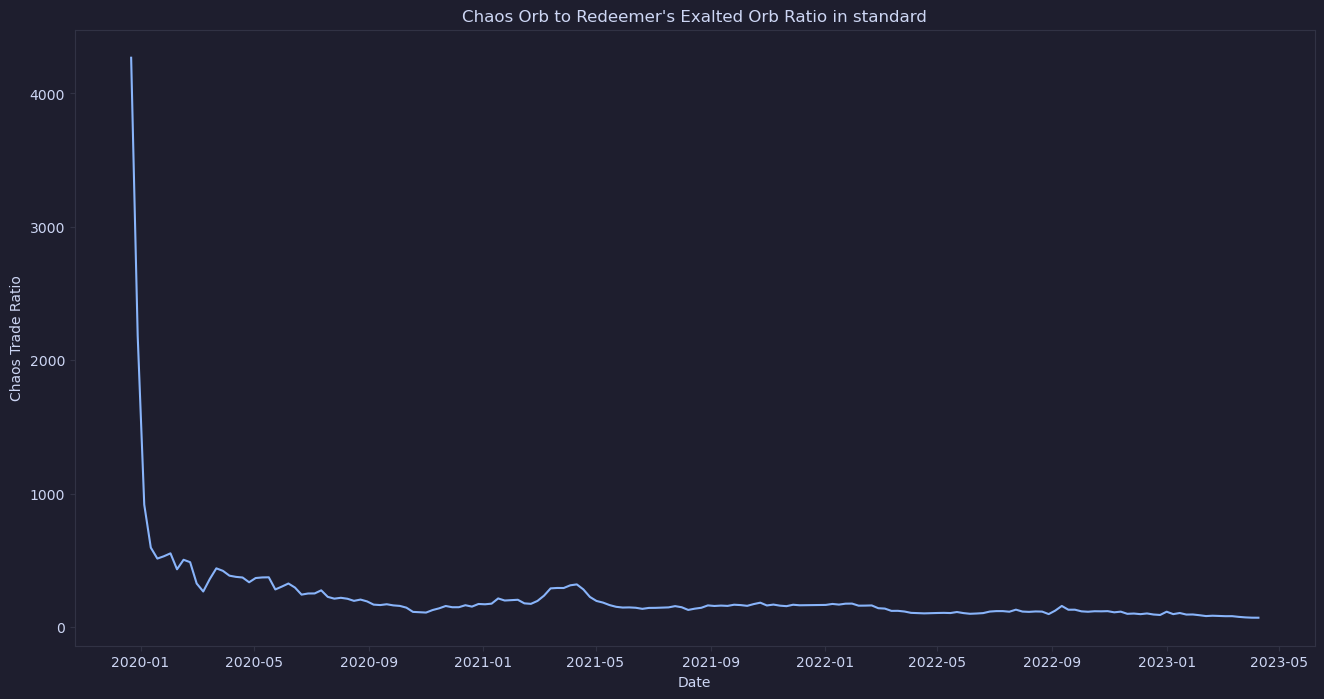

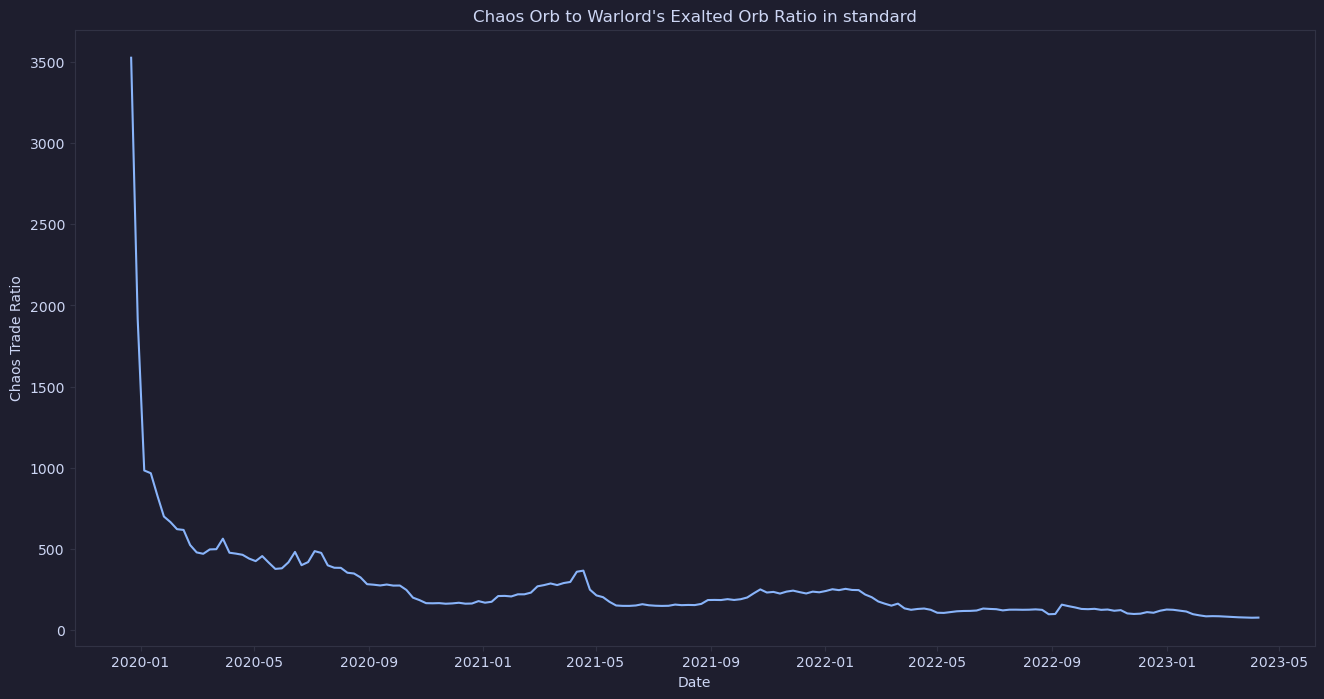

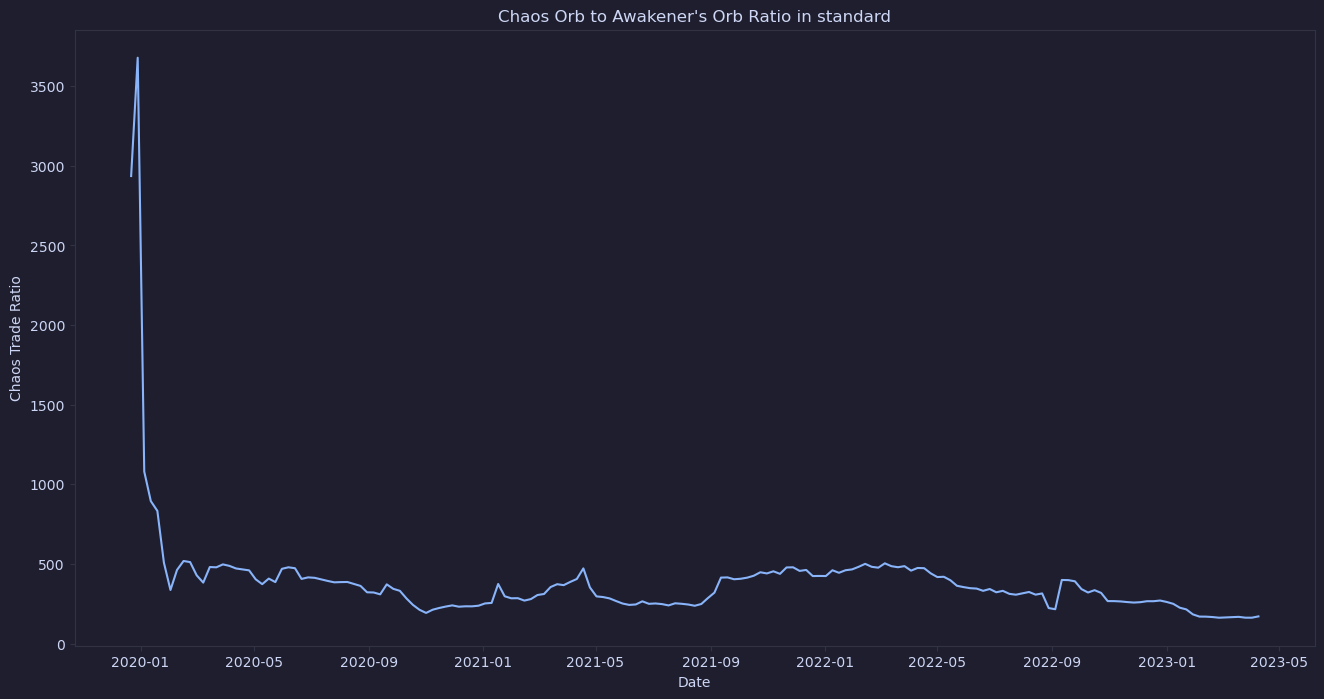

In [151]:
for currency in currencies:
    standard_graph(currency)

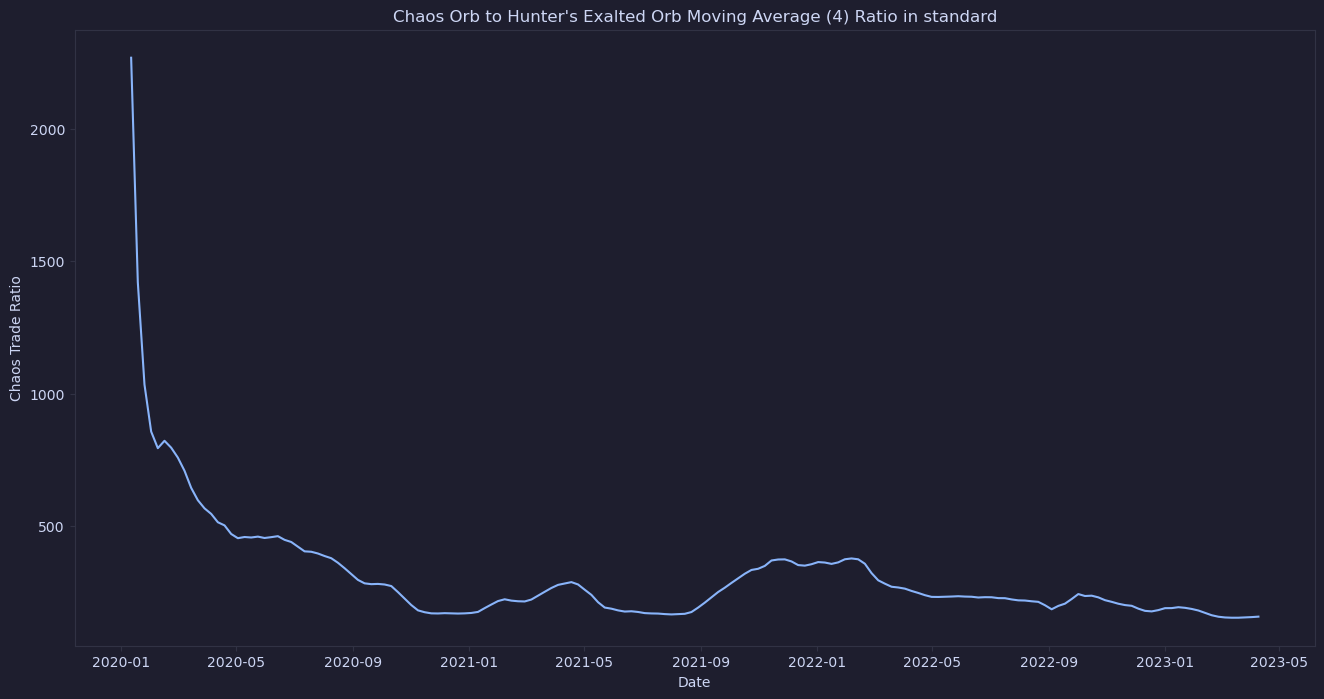

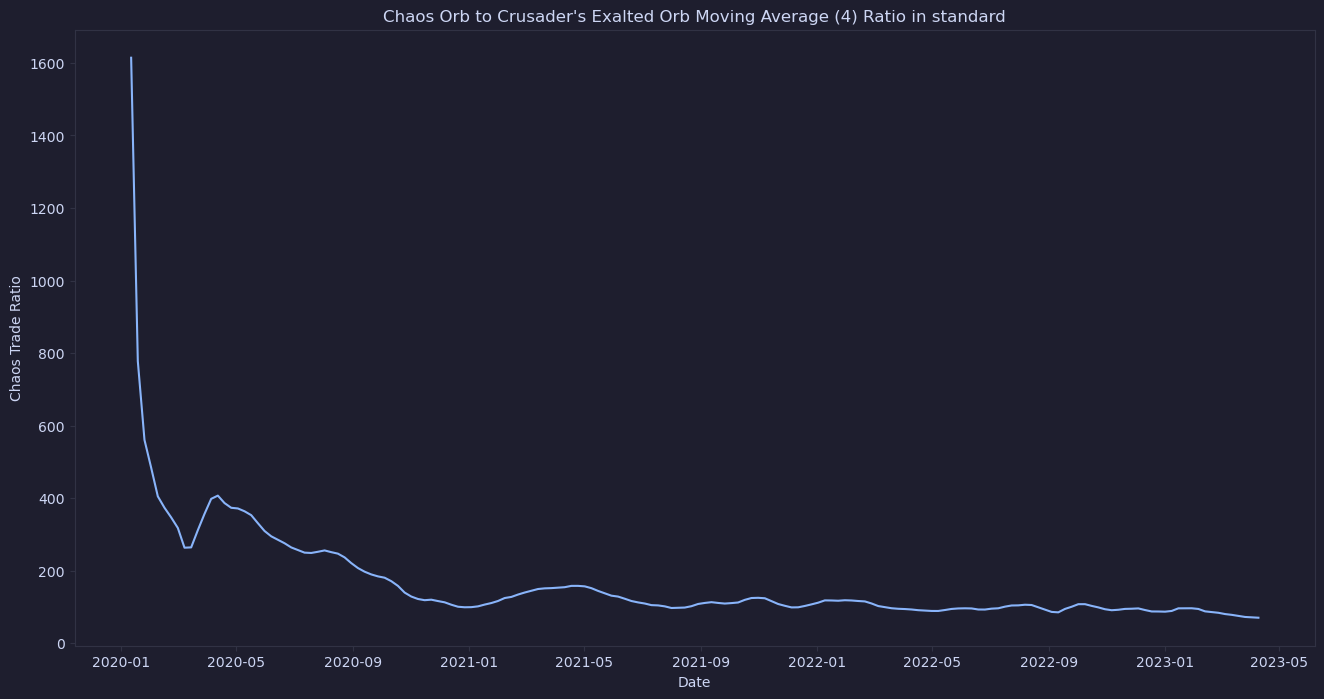

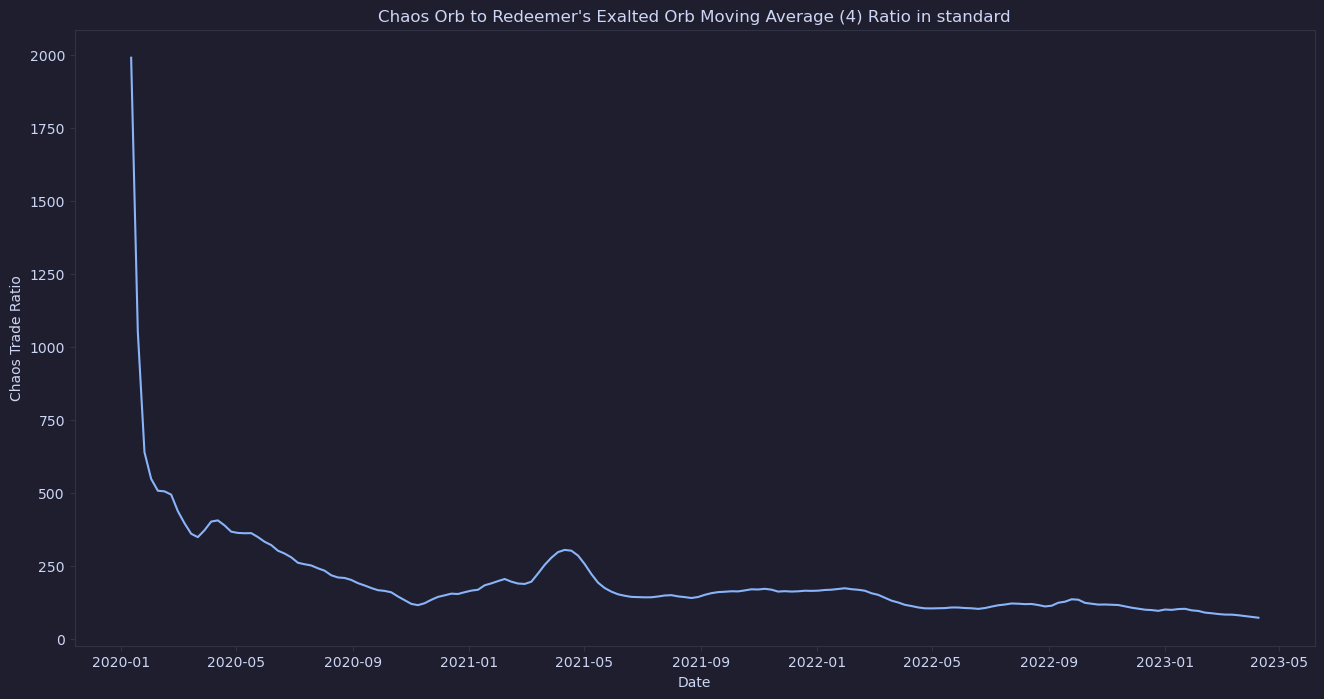

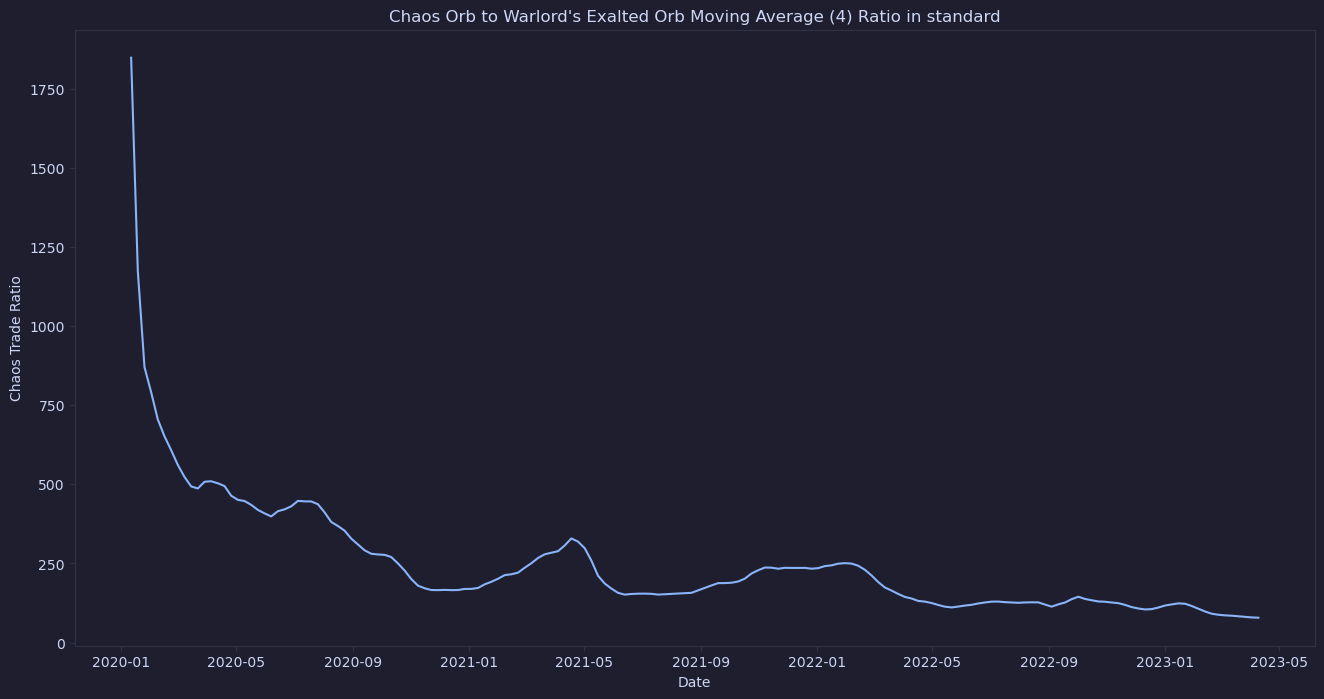

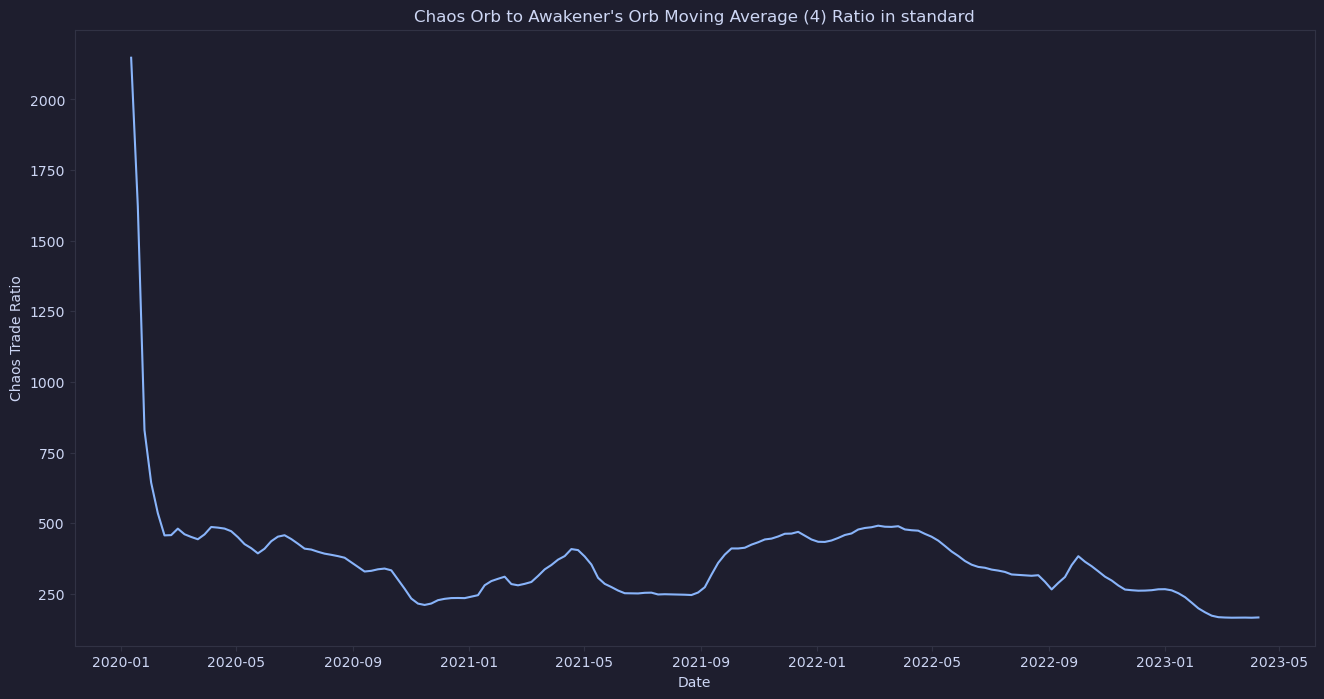

In [152]:
for currency in currencies:
    standard_graph(currency, rolling=4)

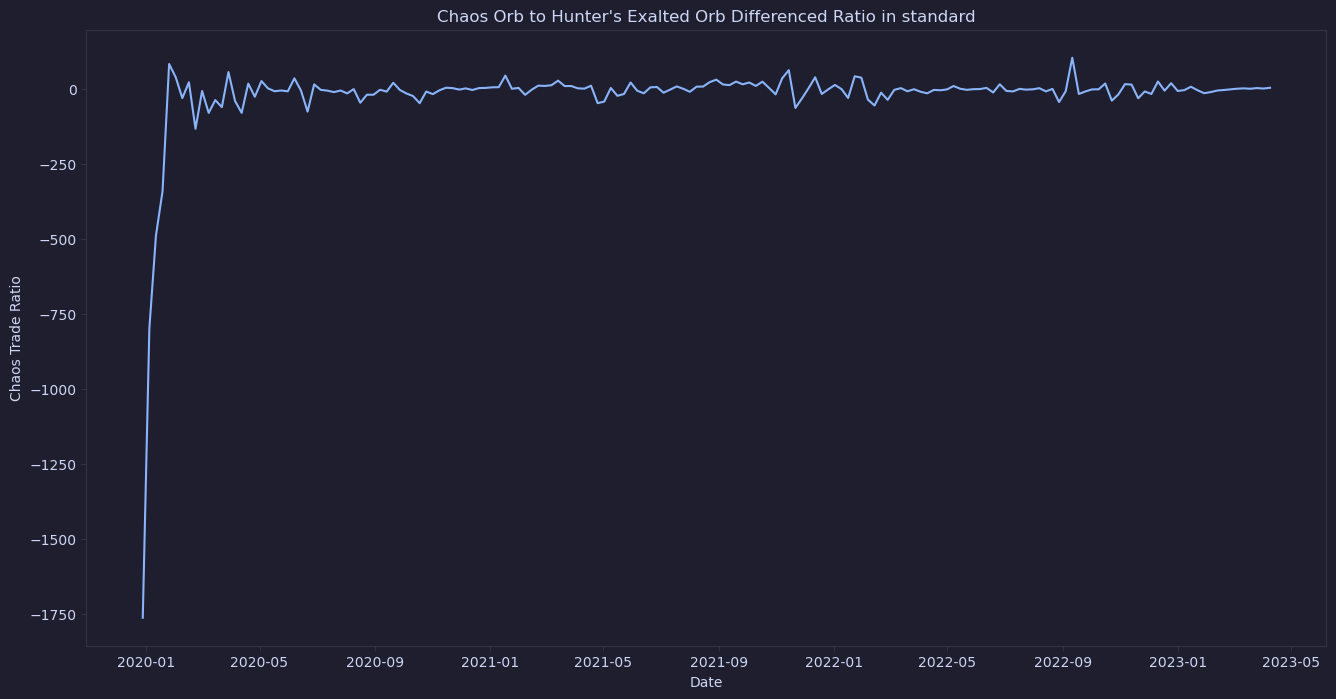

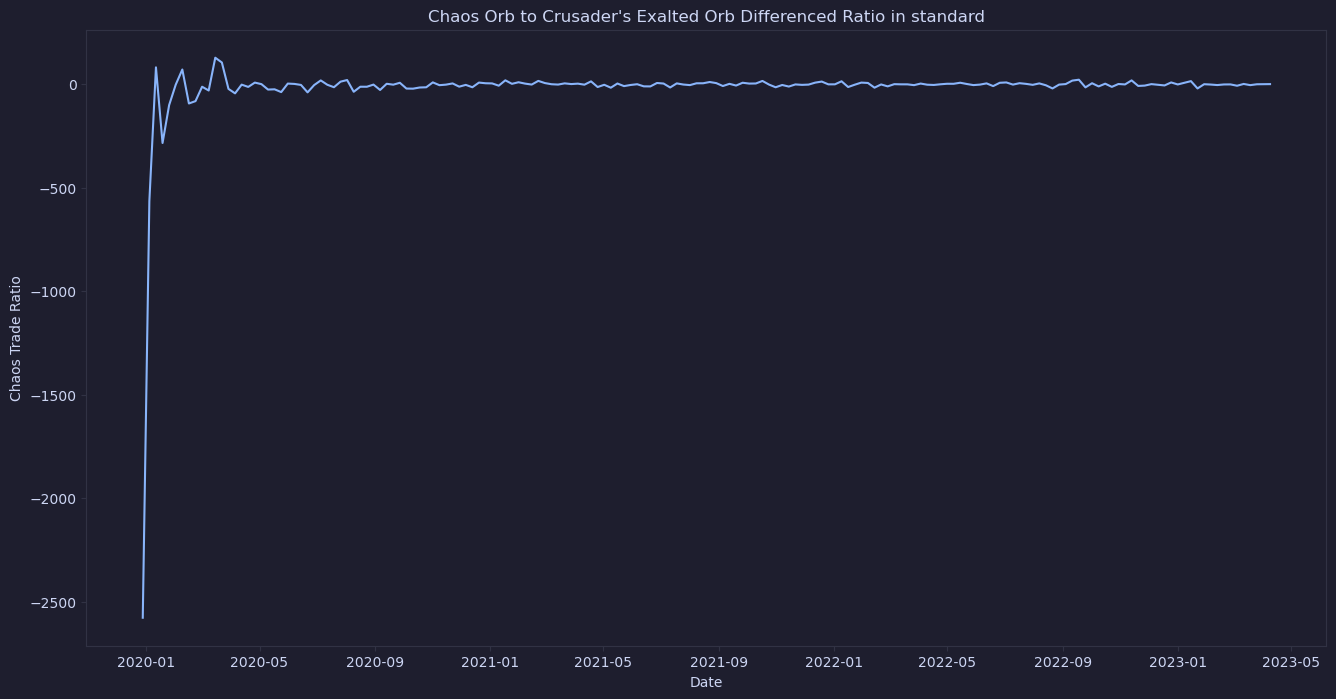

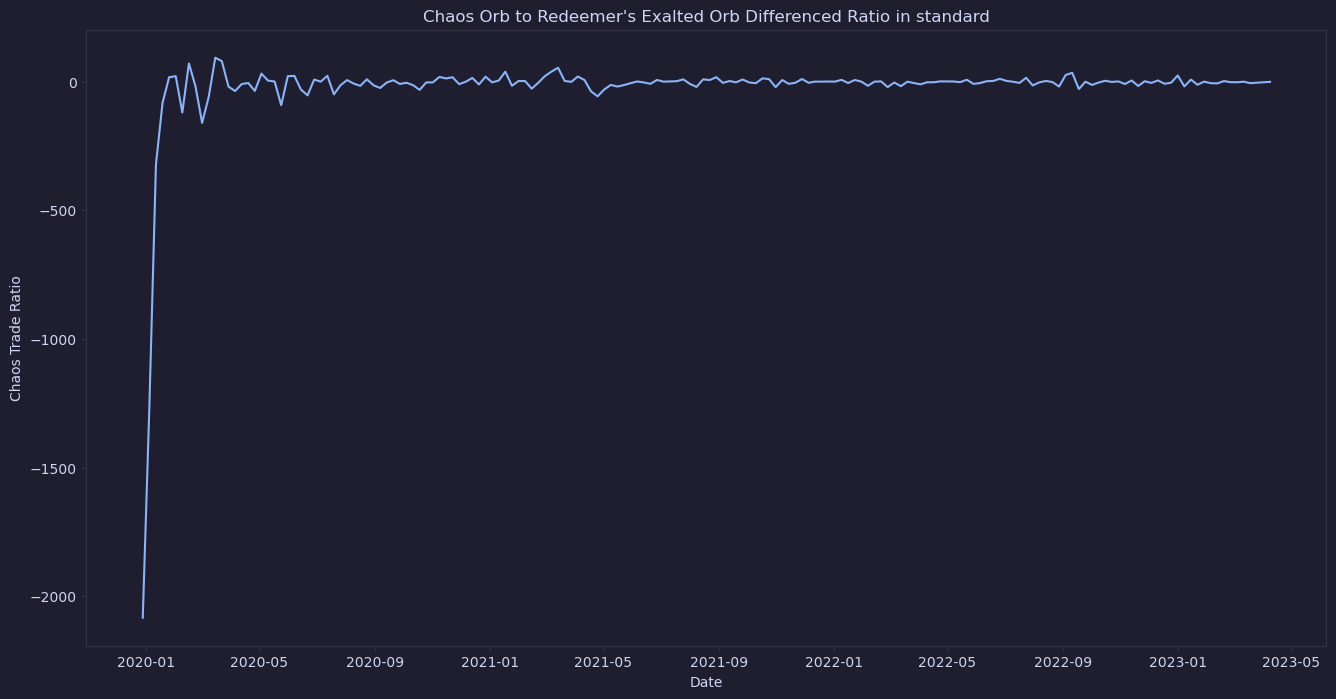

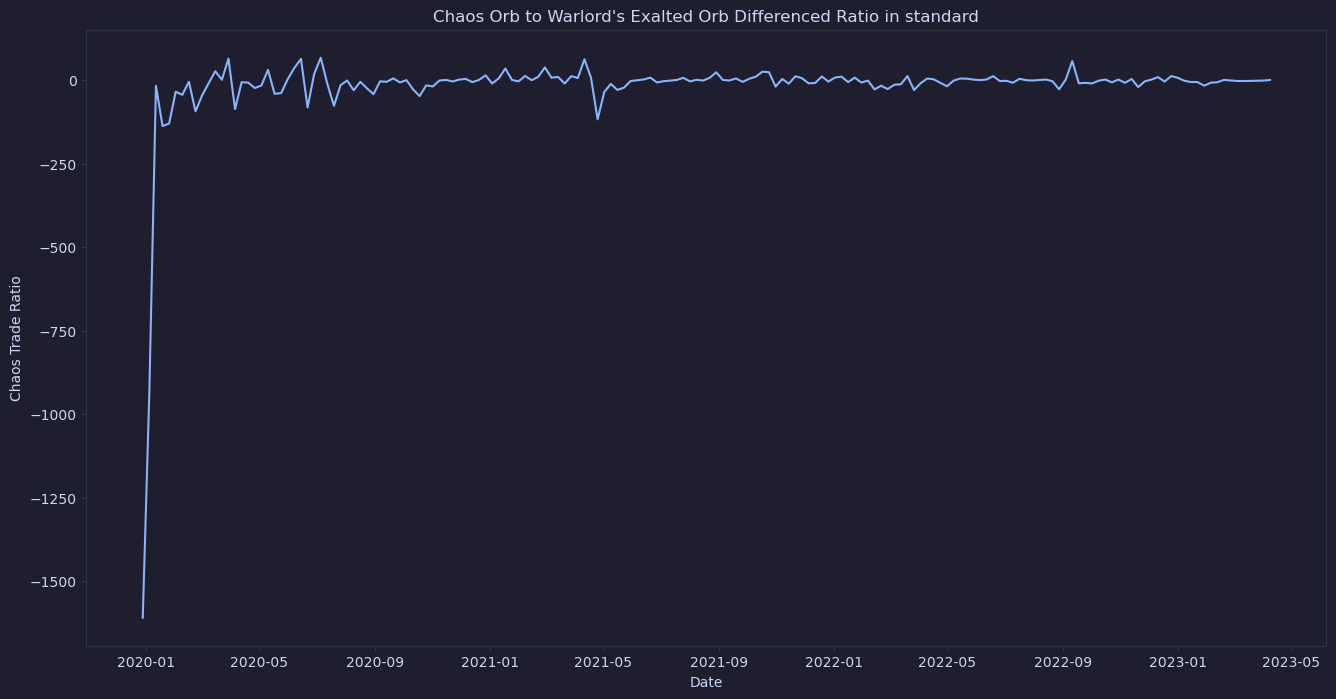

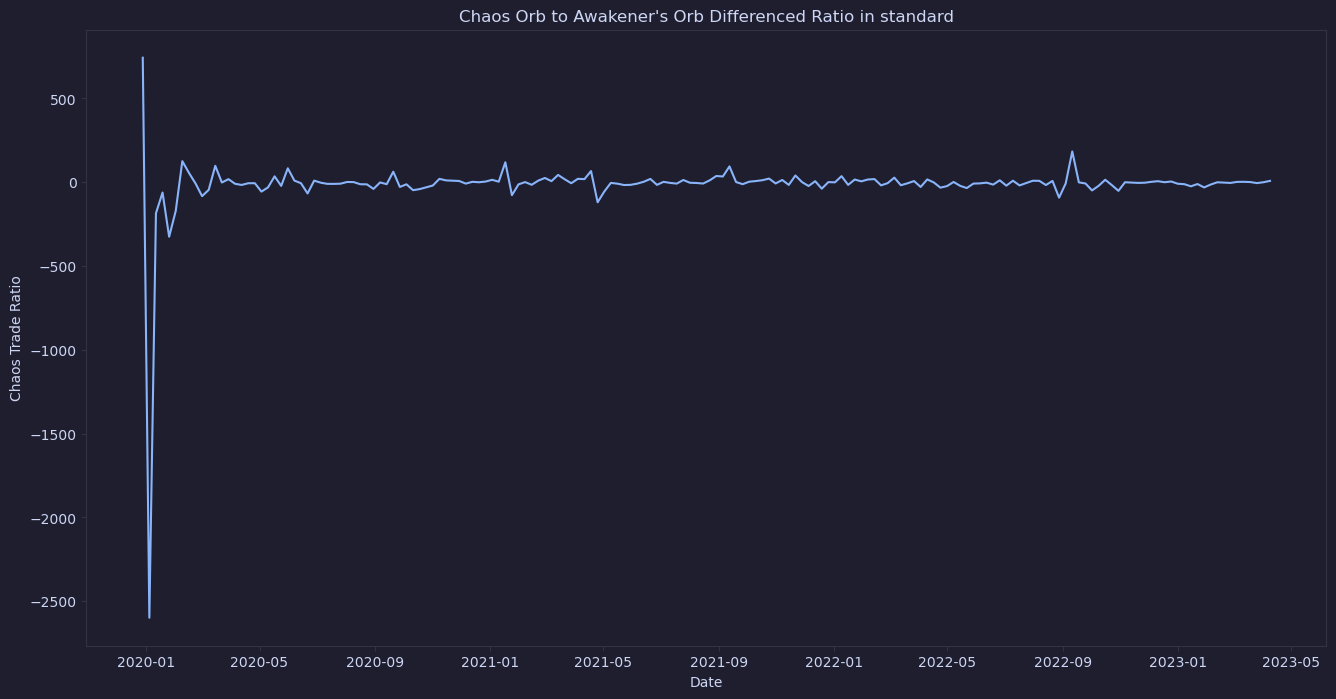

In [153]:
for currency in currencies:
    standard_graph(currency, diffs=1)

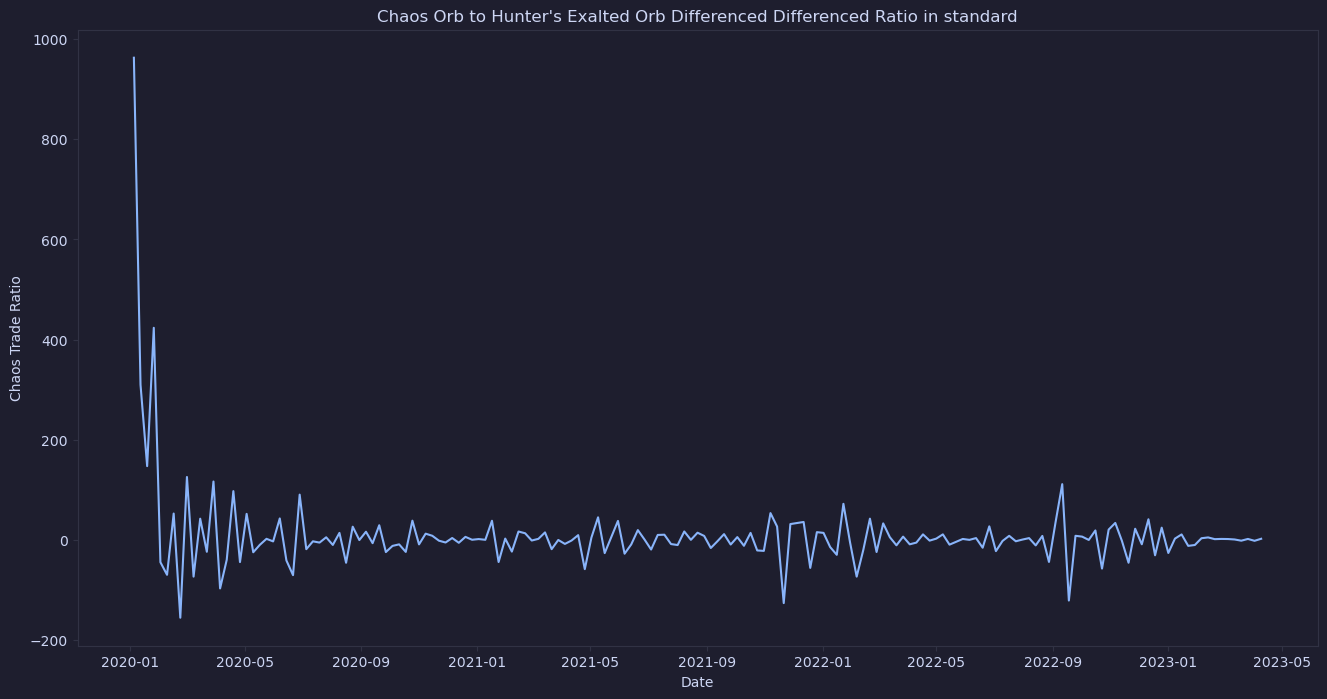

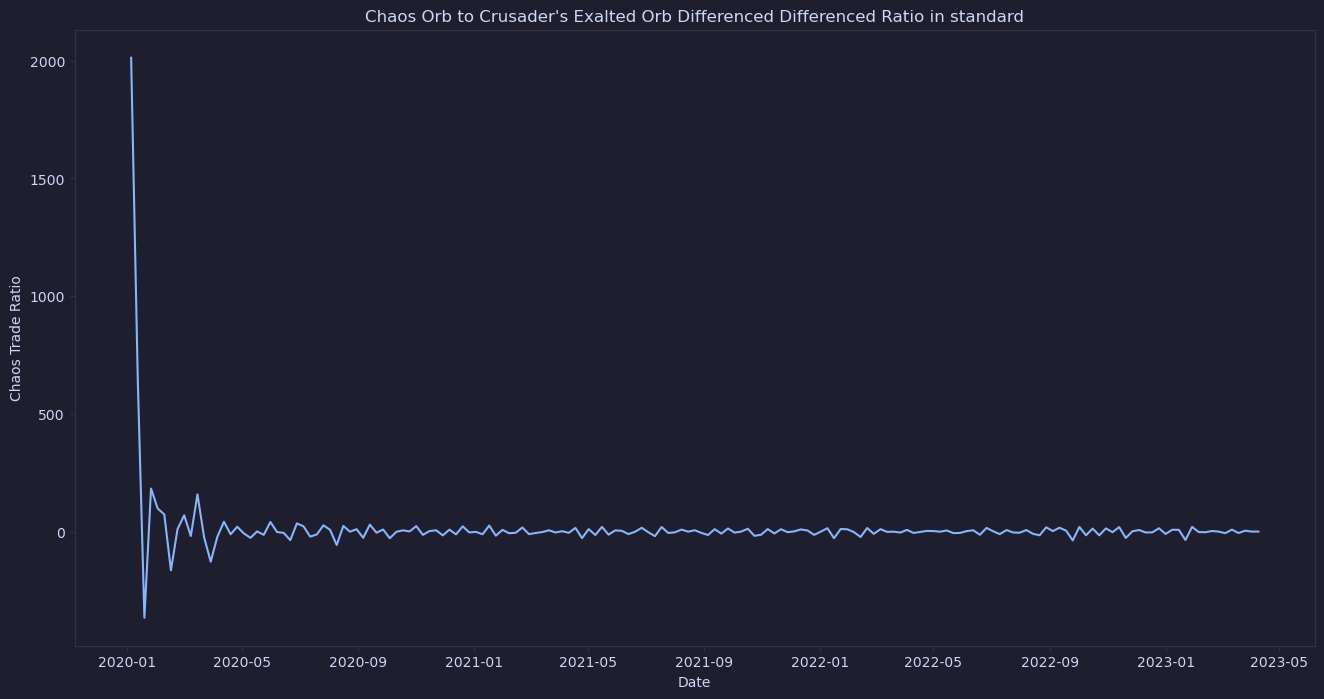

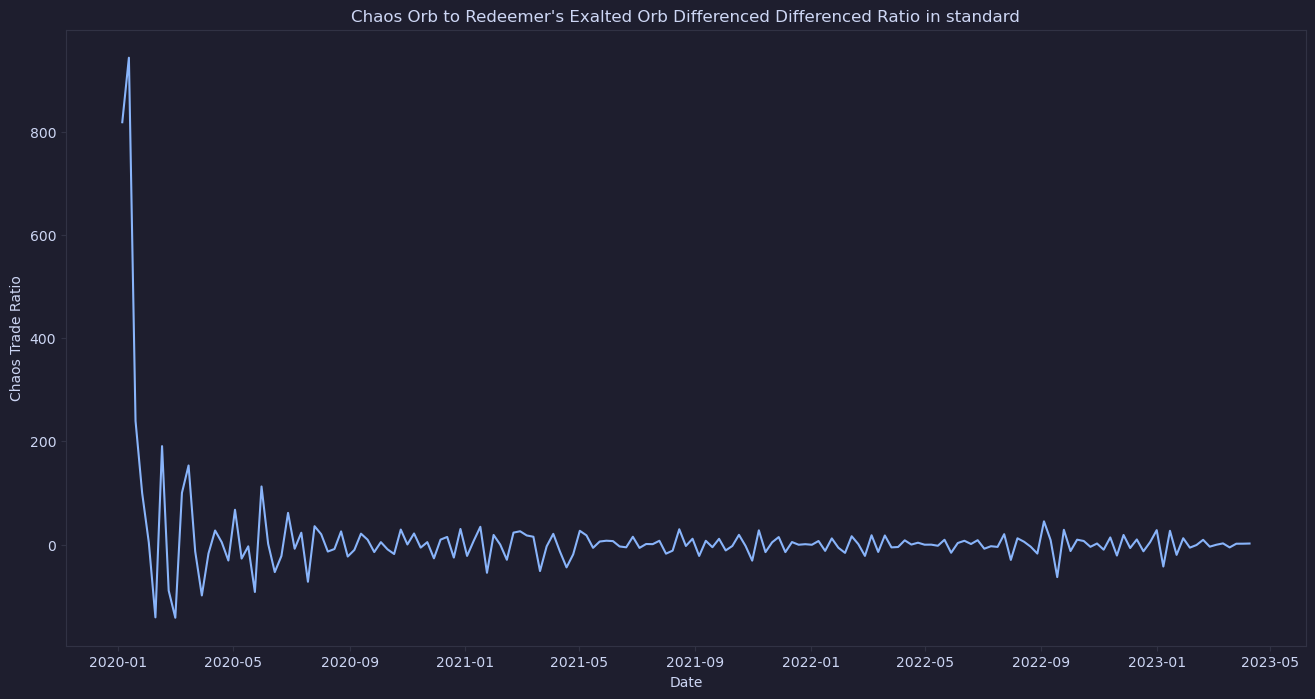

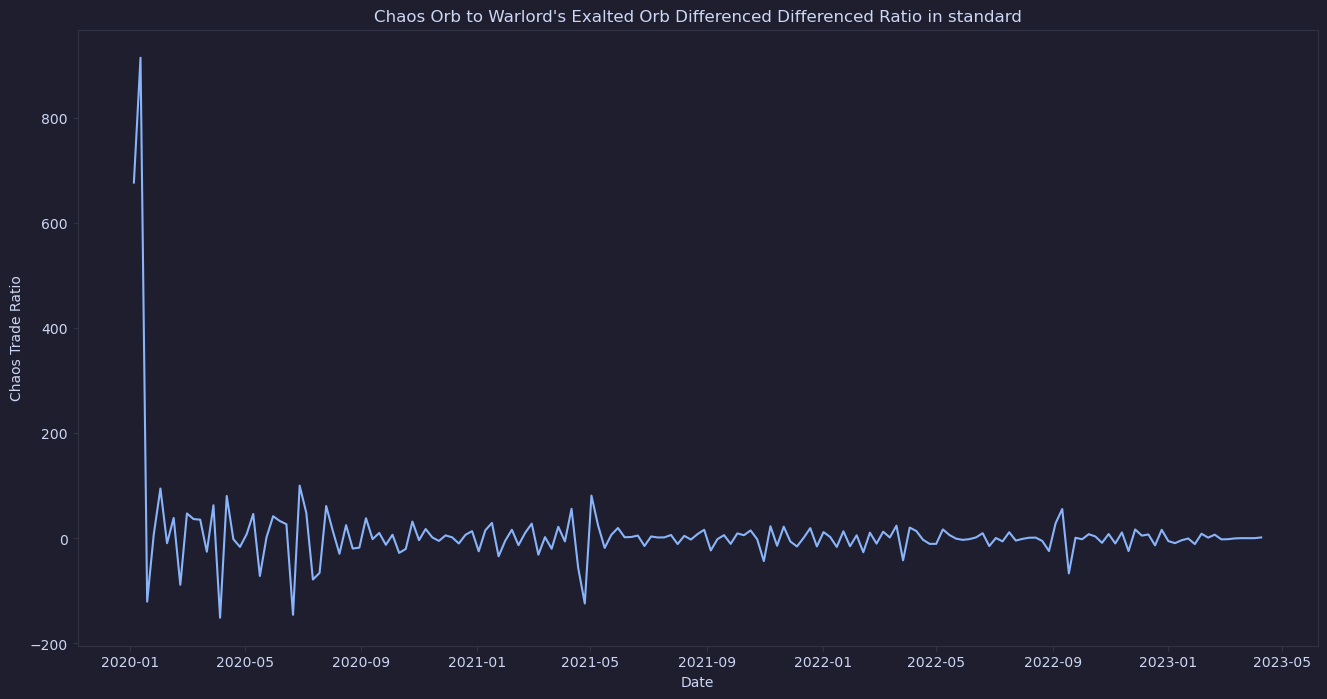

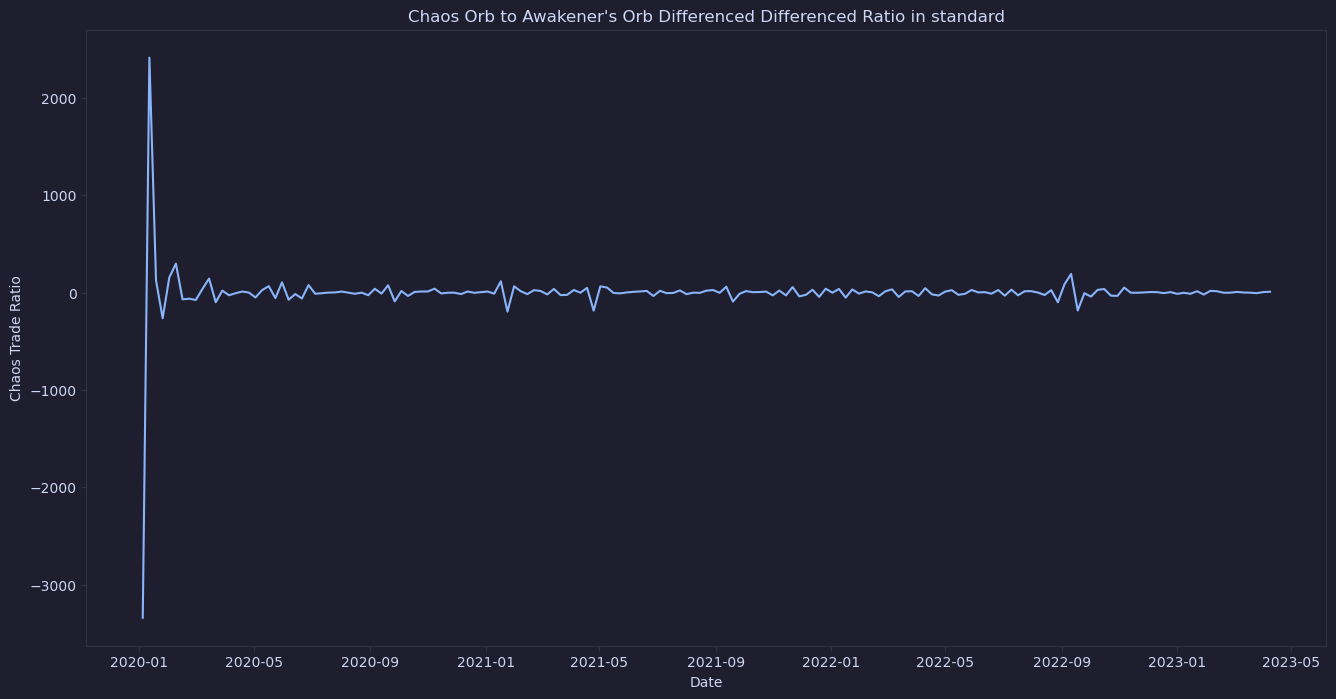

In [154]:
for currency in currencies:
    standard_graph(currency, diffs=2)